In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import Libraries

In [ ]:
import librosa
import numpy as np
import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import scipy.signal as signal
import soundfile as sf
import re
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Preprocessing


## Cut audio files

In [ ]:
def trim_audio(file_path, duration=15):
    y, sr = librosa.load(file_path, sr=None)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    times = librosa.frames_to_time(np.arange(spectral_centroid.shape[1]), sr=sr)
    centroid_index = np.argmax(spectral_centroid)
    centroid_time = times[centroid_index]
    start_time = max(0, centroid_time - duration)
    end_time = min(len(y) / sr, centroid_time + duration)
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    trimmed_y = y[start_sample:end_sample]
    return sr, trimmed_y

## Save audio data
### Cut
### Resample

In [ ]:
audio_folder_identity1 = '/content/drive/My Drive/Final Project/Identity'
audio_folder_identity2 = '/content/drive/My Drive/ML/Final Project/Identity 2'
audio_folder_identity3 = '/content/drive/My Drive/ML/Final Project/Identity3'
audio_folder_gender = '/content/drive/My Drive/Final Project/Gender_data'
audio_files_identity1 = glob.glob(os.path.join(audio_folder_identity1, "*.mp3"))
audio_files_identity2 = glob.glob(os.path.join(audio_folder_identity2, "*.mp3"))
audio_files_identity3 = glob.glob(os.path.join(audio_folder_identity3, "*.mp3"))
audio_files_gender = glob.glob(os.path.join(audio_folder_gender, "*.mp3"))

target_sr = 44100
num = 0
audio_data_identity1 = {}
audio_data_identity2 = {}
audio_data_identity3 = {}
audio_data_gender = {}

In [ ]:
num = 0
for file in audio_files_identity1:
    sr, y = trim_audio(file)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    audio_data_identity1[file] = (y, target_sr)
    num += 1
print(num, " of files are read")
num = 0

42  of files are read


In [ ]:
for file in audio_files_identity2:
    sr, y = trim_audio(file)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    audio_data_identity2[file] = (y, target_sr)
    num += 1
print(num, " of files are read")
num = 0

42  of files are read


In [ ]:
for file in audio_files_identity3:
    sr, y = trim_audio(file)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    audio_data_identity3[file] = (y, target_sr)
    num += 1
print(num, " of files are read")
num = 0

42  of files are read


In [ ]:
for file in audio_files_gender:
    sr, y = trim_audio(file)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    audio_data_gender[file] = (y, target_sr)
    num += 1
print(num, " of files are read")

379  of files are read


## Extract required features

In [ ]:
def extract_features(y, sr):
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
    return np.hstack([spectral_centroid, spectral_rolloff, zero_crossing_rate, mfccs])

## Set parameters

In [ ]:
NOISE_THRESHOLD_CENTROID = 3000
NOISE_THRESHOLD_ROLLOFF = 5000
NOISE_THRESHOLD_ZCR = 0.05

## Recognize noisy features

HW1_Q5_810101551_female.mp3 → Noisy
HW1_Q4_810101551_female.mp3 → Noisy
HW1_Q2_810101551_female.mp3 → Noisy
HW1_Q3_810101551_female.mp3 → Noisy
HW1_Q1_810101551_female.mp3 → Noisy
HW1_intro_810101551_female.mp3 → Noisy
HW1_Q6_810101551_female.mp3 → Noisy
HW1_Q6_810101456_female.mp3 → Clean
HW1_Q4_810101456_female.mp3 → Clean
HW1_Q2_810101456_female.mp3 → Clean
HW1_Q1_810101456_female.mp3 → Noisy
HW1_intro_810101456_female.mp3 → Clean
HW1_Q3_810101456_female.mp3 → Clean
HW1_Q5_810101456_female.mp3 → Clean
HW1_Q6_810100135_female.mp3 → Noisy
HW1_Q2_810100135_female.mp3 → Noisy
HW1_Q5_810100135_female.mp3 → Noisy
HW1_Q1_810100135_female.mp3 → Noisy
HW1_Q4_810100135_female.mp3 → Noisy
HW1_Q3_810100135_female.mp3 → Noisy
HW1_intro_810100135_female.mp3 → Noisy
HW1_Q2_810101465_male.mp3 → Clean
HW1_Q4_810101465_male.mp3 → Clean
HW1_Q5_810101465_male.mp3 → Clean
HW1_Q6_810101465_male.mp3 → Clean
HW1_Q1_810101465_male.mp3 → Clean
HW1_Q3_810101465_male.mp3 → Clean
HW1_Q5_810101419_male.mp3 → Noi

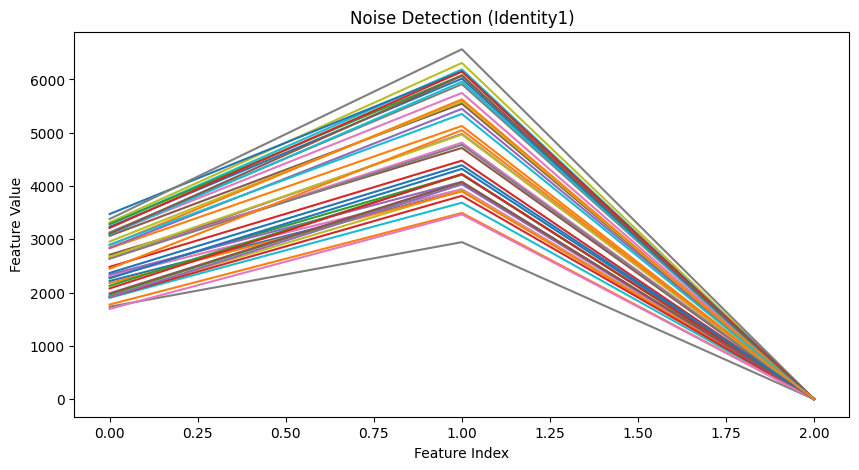

In [ ]:
features_indentity1={}
audio_results_identity1={}
for file,value in audio_data_identity1.items():
    y,sr=value
    feature = extract_features(y, sr)
    features_indentity1[file] = feature
    spectral_centroid, spectral_rolloff, zero_crossing_rate = feature[:3]
    is_noisy = (spectral_centroid > NOISE_THRESHOLD_CENTROID or
                spectral_rolloff > NOISE_THRESHOLD_ROLLOFF or
                zero_crossing_rate > NOISE_THRESHOLD_ZCR)

    audio_results_identity1[file] = "Noisy" if is_noisy else "Clean"

for file, status in audio_results_identity1.items():
    print(f"{os.path.basename(file)} → {status}")

plt.figure(figsize=(10, 5))

for file, feature in features_indentity1.items():
    plt.plot(feature[:3], label=os.path.basename(file))

plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.title("Noise Detection (Identity1)")
plt.show()

HW1_Q1_810103317_male.mp3 → Clean
HW1_Q2_810103317_male.mp3 → Clean
HW1_Q3_810103317_male.mp3 → Clean
HW1_Q4_810103317_male.mp3 → Clean
HW1_Q6_810103317_male.mp3 → Clean
HW1_Q5_810103317_male.mp3 → Clean
HW1_into_810103317_male.mp3 → Clean
HW1_Q2_810103322_male.mp3 → Clean
HW1_Q6_810103322_male.mp3 → Clean
HW1_into_810103322_male.mp3 → Clean
HW1_Q4_810103322_male.mp3 → Clean
HW1_Q1_810103322_male.mp3 → Clean
HW1_Q5_810103322_male.mp3 → Clean
HW1_Q3_810103322_male.mp3 → Clean
HW1_Q4_810103241_male.mp3 → Noisy
HW1_Q2_810103241_male.mp3 → Noisy
HW1_Q3_810103241_male.mp3 → Noisy
HW1_Q1_810103241_male.mp3 → Noisy
HW1_intro_810103241_male.mp3 → Noisy
HW1_Q5_810103241_male.mp3 → Noisy
HW1_Q6_810103241_male.mp3 → Noisy
HW1_Q4_610300070_female.mp3 → Noisy
HW1_intro_610300070_female.mp3 → Noisy
HW1_Q6_610300070_female.mp3 → Clean
HW1_Q3_610300070_female.mp3 → Noisy
HW1_Q5_610300070_female.mp3 → Clean
HW1_Q1_610300070_female.mp3 → Noisy
HW1_Q2_610300070_female.mp3 → Noisy
HW1_Q4_810100075_female.

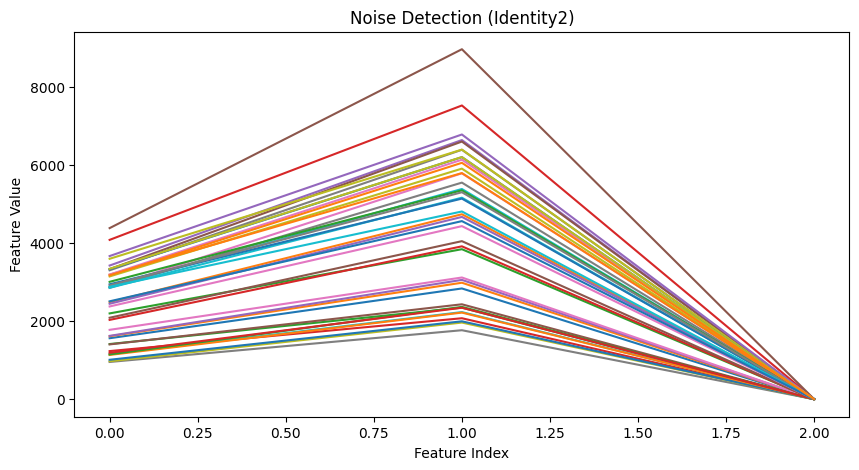

In [ ]:
features_indentity2={}
audio_results_identity2={}
for file,value in audio_data_identity2.items():
    y,sr=value
    feature = extract_features(y, sr)
    features_indentity2[file] = feature
    spectral_centroid, spectral_rolloff, zero_crossing_rate = feature[:3]
    is_noisy = (spectral_centroid > NOISE_THRESHOLD_CENTROID or
                spectral_rolloff > NOISE_THRESHOLD_ROLLOFF or
                zero_crossing_rate > NOISE_THRESHOLD_ZCR)

    audio_results_identity2[file] = "Noisy" if is_noisy else "Clean"

for file, status in audio_results_identity2.items():
    print(f"{os.path.basename(file)} → {status}")

plt.figure(figsize=(10, 5))

for file, feature in features_indentity2.items():
    plt.plot(feature[:3], label=os.path.basename(file))

plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.title("Noise Detection (Identity2)")
plt.show()

HW1_Q2_810100222_female.mp3 → Noisy
HW1_Q1_810100222_female.mp3 → Noisy
HW1_intro_810100222_female.mp3 → Noisy
HW1_Q6_810100222_female.mp3 → Noisy
HW1_Q5_810100222_female.mp3 → Noisy
HW1_Q4_810100222_female.mp3 → Clean
HW1_Q3_810100222_female.mp3 → Noisy
HW1_Q2_810100268_female.mp3 → Noisy
HW1_Q6_810100268_female.mp3 → Noisy
HW1_Q4_810100268_female.mp3 → Noisy
HW1_intro_810100268_female.mp3 → Noisy
HW1_Q3_810100268_female.mp3 → Noisy
HW1_Q5_810100268_female.mp3 → Noisy
HW1_Q1_810100268_female.mp3 → Noisy
HW1_Q2_810100590_female.mp3 → Noisy
HW1_Q6_810100590_female.mp3 → Noisy
HW1_intro_810100590_female.mp3 → Noisy
HW1_Q4_810100590_female.mp3 → Noisy
HW1_Q5_810100590_female.mp3 → Noisy
HW1_Q3_810100590_female.mp3 → Noisy
HW1_Q1_810100590_female.mp3 → Noisy
HW1_Q3_810101540_male.mp3 → Clean
HW1_intro_810101540_male.mp3 → Clean
HW1_Q5_810101540_male.mp3 → Clean
HW1_Q1_810101540_male.mp3 → Clean
HW1_Q4_810101540_male.mp3 → Clean
HW1_Q2_810101540_male.mp3 → Clean
HW1_Q6_810101540_male.mp3 → 

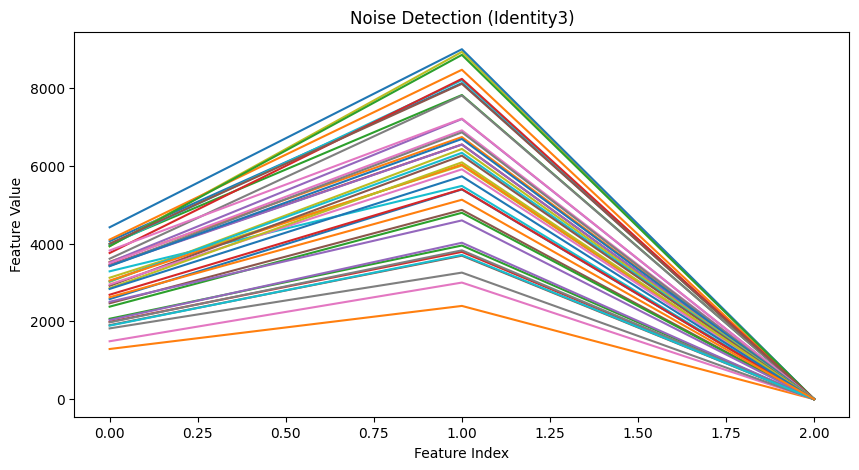

In [ ]:
features_indentity3={}
audio_results_identity3={}
for file,value in audio_data_identity3.items():
    y,sr=value
    feature = extract_features(y, sr)
    features_indentity3[file] = feature
    spectral_centroid, spectral_rolloff, zero_crossing_rate = feature[:3]
    is_noisy = (spectral_centroid > NOISE_THRESHOLD_CENTROID or
                spectral_rolloff > NOISE_THRESHOLD_ROLLOFF or
                zero_crossing_rate > NOISE_THRESHOLD_ZCR)

    audio_results_identity3[file] = "Noisy" if is_noisy else "Clean"

for file, status in audio_results_identity3.items():
    print(f"{os.path.basename(file)} → {status}")

plt.figure(figsize=(10, 5))

for file, feature in features_indentity3.items():
    plt.plot(feature[:3], label=os.path.basename(file))

plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.title("Noise Detection (Identity3)")
plt.show()

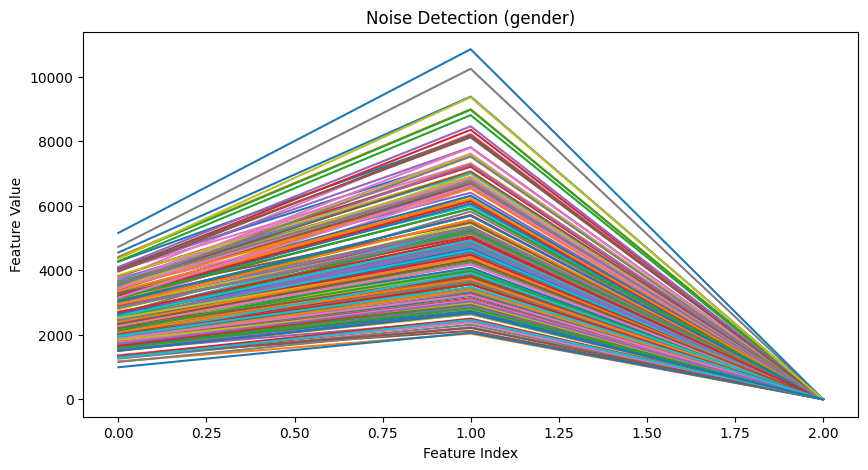

In [ ]:
features_gender ={}
audio_results_gender={}
for file,value in audio_data_gender.items():
    y,sr=value
    feature = extract_features(y, sr)
    features_gender[file] = feature
    spectral_centroid, spectral_rolloff, zero_crossing_rate = feature[:3]
    is_noisy = (spectral_centroid > NOISE_THRESHOLD_CENTROID or
                spectral_rolloff > NOISE_THRESHOLD_ROLLOFF or
                zero_crossing_rate > NOISE_THRESHOLD_ZCR)

    audio_results_gender[file] = "Noisy" if is_noisy else "Clean"

plt.figure(figsize=(10, 5))

for file, feature in features_gender.items():
    plt.plot(feature[:3], label=os.path.basename(file))

plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.title("Noise Detection (gender)")
plt.show()

## Noise handling

In [ ]:
def spectral_subtraction(y, sr, noise_factor=0.1):
    D = librosa.stft(y)
    magnitude, phase = np.abs(D), np.angle(D)

    noise_estimate = np.mean(magnitude[:, :10], axis=1, keepdims=True)
    magnitude = np.maximum(magnitude - noise_factor * noise_estimate, 0)

    D_denoised = magnitude * np.exp(1j * phase)
    y_denoised = librosa.istft(D_denoised)

    return y_denoised

def butter_bandpass(lowcut, highcut, sr, order=4):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(y, sr, lowcut=300, highcut=3400):
    b, a = butter_bandpass(lowcut, highcut, sr)
    y_filtered = signal.filtfilt(b, a, y)
    return y_filtered

In [ ]:
num = 0
for file,value in audio_results_identity1.items():
    if value == "Noisy":
      num += 1
      y, sr = audio_data_identity1[file]
      y_denoised=spectral_subtraction(y,sr)
      y_filtered = apply_bandpass_filter(y, sr)
      audio_data_identity1[file] = (y_filtered , sr)
      features_indentity1[file] = extract_features(y_filtered, sr)

      plt.figure(figsize=(12, 6))

      plt.subplot(2, 1, 1)
      librosa.display.waveshow(y, sr=sr, alpha=0.5)
      plt.title("Original Audio")

      plt.subplot(2, 1, 2)
      librosa.display.waveshow(y_filtered, sr=sr, alpha=0.5, color='r')
      plt.title("Processed Audio (Spectral Subtraction + Bandpass)")

      plt.tight_layout()
      plt.show()
print("number of noisy data: ", num)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
num = 0
for file,value in audio_results_identity2.items():
    if value == "Noisy":
      num += 1
      y, sr = audio_data_identity2[file]
      y_denoised=spectral_subtraction(y,sr)
      y_filtered = apply_bandpass_filter(y, sr)
      audio_data_identity2[file] = (y_filtered , sr)
      features_indentity2[file] = extract_features(y_filtered, sr)

      plt.figure(figsize=(12, 6))

      plt.subplot(2, 1, 1)
      librosa.display.waveshow(y, sr=sr, alpha=0.5)
      plt.title("Original Audio")

      plt.subplot(2, 1, 2)
      librosa.display.waveshow(y_filtered, sr=sr, alpha=0.5, color='r')
      plt.title("Processed Audio (Spectral Subtraction + Bandpass)")

      plt.tight_layout()
      plt.show()
print("number of noisy data: ", num)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
num = 0
for file,value in audio_results_identity3.items():
    if value == "Noisy":
      num += 1
      y, sr = audio_data_identity3[file]
      y_denoised=spectral_subtraction(y,sr)
      y_filtered = apply_bandpass_filter(y, sr)
      audio_data_identity3[file] = (y_filtered , sr)
      features_indentity3[file] = extract_features(y_filtered, sr)

      plt.figure(figsize=(12, 6))

      plt.subplot(2, 1, 1)
      librosa.display.waveshow(y, sr=sr, alpha=0.5)
      plt.title("Original Audio")

      plt.subplot(2, 1, 2)
      librosa.display.waveshow(y_filtered, sr=sr, alpha=0.5, color='r')
      plt.title("Processed Audio (Spectral Subtraction + Bandpass)")

      plt.tight_layout()
      plt.show()
print("number of noisy data: ", num)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
num = 0
for file,value in audio_results_gender.items():
    if value == "Noisy":
      num += 1
      y, sr = audio_data_gender[file]
      y_denoised=spectral_subtraction(y,sr)
      y_filtered = apply_bandpass_filter(y, sr)
      audio_data_gender[file] = (y_filtered , sr)
      features_gender[file] = extract_features(y_filtered, sr)

print("number of noisy data: ", num)

number of noisy data:  169


## Check the result of noise handling

In [ ]:
num = 0
for file,value in audio_data_identity1.items():
    y,sr=value
    feature = extract_features(y, sr)
    spectral_centroid, spectral_rolloff, zero_crossing_rate = feature[:3]
    is_noisy = (spectral_centroid > NOISE_THRESHOLD_CENTROID or
                spectral_rolloff > NOISE_THRESHOLD_ROLLOFF or
                zero_crossing_rate > NOISE_THRESHOLD_ZCR)

    audio_results_identity1[file] = "Noisy" if is_noisy else "Clean"

for file, status in audio_results_identity1.items():
    if audio_results_identity1[file] == "Noisy":
      num += 1
print(num, " voices remained noisy")

0  voices remained noisy


In [ ]:
num = 0
for file,value in audio_data_identity2.items():
    y,sr=value
    feature = extract_features(y, sr)
    spectral_centroid, spectral_rolloff, zero_crossing_rate = feature[:3]
    is_noisy = (spectral_centroid > NOISE_THRESHOLD_CENTROID or
                spectral_rolloff > NOISE_THRESHOLD_ROLLOFF or
                zero_crossing_rate > NOISE_THRESHOLD_ZCR)

    audio_results_identity2[file] = "Noisy" if is_noisy else "Clean"

for file, status in audio_results_identity2.items():
    if audio_results_identity2[file] == "Noisy":
      num += 1
print(num, " voices remained noisy")

5  voices remained noisy


In [ ]:
num = 0
for file,value in audio_data_identity3.items():
    y,sr=value
    feature = extract_features(y, sr)
    spectral_centroid, spectral_rolloff, zero_crossing_rate = feature[:3]
    is_noisy = (spectral_centroid > NOISE_THRESHOLD_CENTROID or
                spectral_rolloff > NOISE_THRESHOLD_ROLLOFF or
                zero_crossing_rate > NOISE_THRESHOLD_ZCR)

    audio_results_identity3[file] = "Noisy" if is_noisy else "Clean"

for file, status in audio_results_identity3.items():
    if audio_results_identity3[file] == "Noisy":
      num += 1
print(num, " voices remained noisy")

1  voices remained noisy


In [ ]:
num = 0
for file,value in audio_data_gender.items():
    y,sr=value
    feature = extract_features(y, sr)
    spectral_centroid, spectral_rolloff, zero_crossing_rate = feature[:3]
    is_noisy = (spectral_centroid > NOISE_THRESHOLD_CENTROID or
                spectral_rolloff > NOISE_THRESHOLD_ROLLOFF or
                zero_crossing_rate > NOISE_THRESHOLD_ZCR)

    audio_results_gender[file] = "Noisy" if is_noisy else "Clean"

for file, status in audio_results_gender.items():
    if audio_results_gender[file] == "Noisy":
      num += 1
print(num, " voices remained noisy")

20  voices remained noisy


## Delete unusable audio data

In [ ]:
files = []
for file, value in audio_results_identity1.items():
  if audio_results_identity1[file] == "Noisy":
    files.append(file)
    print(file)
print(len(audio_data_identity1))
for file in files:
    audio_results_identity1.pop(file)
    audio_data_identity1.pop(file)
    features_indentity1.pop(file)
print(len(audio_data_identity1))

42
42


In [ ]:
files = []
for file, value in audio_results_identity2.items():
  if audio_results_identity2[file] == "Noisy":
    files.append(file)
    print(file)
print(len(audio_data_identity2))
for file in files:
    audio_results_identity2.pop(file)
    audio_data_identity2.pop(file)
    features_indentity2.pop(file)
print(len(audio_data_identity2))

/content/drive/My Drive/ML/Final Project/Identity 2/HW1_Q2_810103241_male.mp3
/content/drive/My Drive/ML/Final Project/Identity 2/HW1_Q1_810103241_male.mp3
/content/drive/My Drive/ML/Final Project/Identity 2/HW1_intro_810103241_male.mp3
/content/drive/My Drive/ML/Final Project/Identity 2/HW1_Q5_810103241_male.mp3
/content/drive/My Drive/ML/Final Project/Identity 2/HW1_Q6_810103241_male.mp3
42
37


In [ ]:
files = []
for file, value in audio_results_identity3.items():
  if audio_results_identity3[file] == "Noisy":
    files.append(file)
    print(file)
print(len(audio_data_identity3))
for file in files:
    audio_results_identity3.pop(file)
    audio_data_identity3.pop(file)
    features_indentity3.pop(file)
print(len(audio_data_identity3))

/content/drive/My Drive/ML/Final Project/Identity3/HW1_intro_810101575_male.mp3
42
41


In [ ]:
files = []
for file, value in audio_results_gender.items():
  if audio_results_gender[file] == "Noisy":
    files.append(file)
    print(file)
print(len(audio_data_gender))
for file in files:
    audio_results_gender.pop(file)
    audio_data_gender.pop(file)
    features_gender.pop(file)
print(len(audio_data_gender))

/content/drive/My Drive/Final Project/Gender_data/HW1_intor_810103241_male.mp3
/content/drive/My Drive/Final Project/Gender_data/HW1_intro_810100269_male.mp3
/content/drive/My Drive/Final Project/Gender_data/HW1_intro_810101575_male.mp3
/content/drive/My Drive/Final Project/Gender_data/HW1_intro_810102032_male.mp3
/content/drive/My Drive/Final Project/Gender_data/HW1_intro_810102345_male.mp3
/content/drive/My Drive/Final Project/Gender_data/HW1_intro_810103222_male.mp3
/content/drive/My Drive/Final Project/Gender_data/HW1_intro_810103241_male.mp3
/content/drive/My Drive/Final Project/Gender_data/HW1_intro_810103245_male.mp3
/content/drive/My Drive/Final Project/Gender_data/HW1_intro_810103269_male.mp3
/content/drive/My Drive/Final Project/Gender_data/HW1_intro_810199328_male.mp3
/content/drive/My Drive/Final Project/Gender_data/HW1_intro_810600072_male.mp3
/content/drive/My Drive/Final Project/Gender_data/HW1_Q1_810103306_male.mp3
/content/drive/My Drive/Final Project/Gender_data/HW1_Q

## Normalize audio data

In [ ]:
for file, value in audio_data_identity1.items():
  y, sr = audio_data_identity1[file]
  y_norm = librosa.util.normalize(y)
  audio_data_identity1[file] = (y_norm,sr)

In [ ]:
for file, value in audio_data_identity2.items():
  y, sr = audio_data_identity2[file]
  y_norm = librosa.util.normalize(y)
  audio_data_identity2[file] = (y_norm,sr)

for file, value in audio_data_identity3.items():
  y, sr = audio_data_identity3[file]
  y_norm = librosa.util.normalize(y)
  audio_data_identity3[file] = (y_norm,sr)

In [ ]:
for file, value in audio_data_gender.items():
  y, sr = audio_data_gender[file]
  y_norm = librosa.util.normalize(y)
  audio_data_gender[file] = (y_norm,sr)

## Encode gender section

In [ ]:
def detect_gender(text):
    text = text.lower()
    if "female" in text:
        return 1
    elif "male" in text:
        return 0
    else:
        return None

## Split file path segments

In [ ]:
def split_segments(s):
    return re.split(r'[_\.]', s)

## Extract required features for training

In [ ]:
def extract_audio_features(file_path, y, sr, n_mfcc=13, n_mels=128):
    log_mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels))
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    energy = librosa.feature.rms(y=y)
    gender = detect_gender(file_path)
    id = split_segments(file_path)[2]
    return {
        "Log_Mel_Spectrogram": log_mel_spec,
        "MFCC": mfcc,
        "Spectral_Centroid": spectral_centroid,
        "Bandwidth": bandwidth,
        "Spectral_Contrast": spectral_contrast,
        "Zero_Crossing_Rate": zero_crossing_rate,
        "Energy": energy,
        "Gender": gender,
        "STID": id
    }

## Save features of audio data

In [ ]:
audio_details_identity1 = []
for file, (y, sr) in audio_data_identity1.items():
    details = extract_audio_features(file, y, sr)
    audio_details_identity1.append(details)

In [ ]:
audio_details_identity2 = []
for file, (y, sr) in audio_data_identity2.items():
    details = extract_audio_features(file, y, sr)
    audio_details_identity2.append(details)

audio_details_identity3 = []
for file, (y, sr) in audio_data_identity3.items():
    details = extract_audio_features(file, y, sr)
    audio_details_identity3.append(details)

In [ ]:
audio_details_gender = []
for file, (y, sr) in audio_data_gender.items():
    details = extract_audio_features(file, y, sr)
    audio_details_gender.append(details)

## Convert data to data frame

In [ ]:
df_identity1 = pd.DataFrame(audio_details_identity1)
df_identity1.head()

Log_Mel_Spectrogram  \
0  [[-22.57332182809629, -28.295782386398628, -45...   
1  [[-24.235916311380606, -30.202685034768884, -4...   
2  [[-19.952038613150066, -26.062534918949815, -4...   
3  [[-11.009839914010593, -17.091016422962657, -4...   
4  [[-35.39879457892274, -40.06223991438229, -45....   

                                                MFCC  \
0  [[-286.8047790134551, -303.5843110329075, -329...   
1  [[-419.2930621469898, -401.1195911649325, -298...   
2  [[-393.8493250612197, -393.74782433396797, -41...   
3  [[-294.0582574271171, -310.68520493885626, -33...   
4  [[-349.35254820248247, -351.10903672295063, -3...   

                                   Spectral_Centroid  \
0  [[1146.1331635081046, 954.7189611576457, 746.6...   
1  [[1971.2330992884492, 1780.7239541012564, 2119...   
2  [[1553.8345083144245, 1278.6710544786797, 913....   
3  [[1437.832122501708, 1155.1326738740245, 951.3...   
4  [[1391.4211047375684, 1056.8978881933415, 803....   

                                           Bandwidth  \
0  [[2267.070738642417, 1677.6365556799803, 519.2...   
1  [[3799.021858973857, 2657.608123851938, 1148.8...   
2  [[3266.590137977108, 2576.8609722856845, 834.5...   
3  [[2536.7698767508955, 1840.9050695014637, 723....   
4  [[2827.6690741455495, 2043.1806983477766, 550....   

                                   Spectral_Contrast  \
0  [[3.5186802079973027, 3.8887808955787246, 20.7...   
1  [[2.2567123369106605, 2.0450193596796904, 19.9...   
2  [[1.7395067051531865, 1.9255691505765506, 19.9...   
3  [[1.2003316641704305, 0.9625453915492814, 29.6...   
4  [[5.036595122429661, 3.054562637726441, 20.890...   

                                  Zero_Crossing_Rate  \
0  [[0.01220703125, 0.0185546875, 0.02490234375, ...   
1  [[0.01025390625, 0.02978515625, 0.037109375, 0...   
2  [[0.009765625, 0.01611328125, 0.0224609375, 0....   
3  [[0.015625, 0.02294921875, 0.03173828125, 0.03...   
4  [[0.01513671875, 0.02294921875, 0.0341796875, ...   

                                              Energy  Gender       STID  
0  [[0.08719148, 0.104803905, 0.12385833, 0.11492...       1  810101551  
1  [[0.0038286496, 0.02268922, 0.03702562, 0.0388...       1  810101551  
2  [[0.009393975, 0.009794941, 0.0104258545, 0.00...       1  810101551  
3  [[0.04648404, 0.060950246, 0.0706342, 0.073679...       1  810101551  
4  [[0.027652983, 0.0280223, 0.028096933, 0.01009...       1  810101551

In [ ]:
df_identity2 = pd.DataFrame(audio_details_identity2)
df_identity2.head()

Log_Mel_Spectrogram  \
0  [[-17.516073, -7.235892, -5.602435, -7.126652,...   
1  [[-50.761154, -50.761154, -50.761154, -50.7611...   
2  [[-48.825188, -48.825188, -48.825188, -48.8251...   
3  [[-46.42678, -46.42678, -46.42678, -46.42678, ...   
4  [[-47.127716, -47.127716, -47.127716, -47.1277...   

                                                MFCC  \
0  [[-281.05438, -251.16194, -254.35106, -266.476...   
1  [[-574.2969, -574.2969, -574.2969, -574.2969, ...   
2  [[-552.3939, -552.3939, -552.3939, -552.3939, ...   
3  [[-525.25903, -525.25903, -525.25903, -525.259...   
4  [[-533.1892, -533.1892, -533.1892, -533.1892, ...   

                                   Spectral_Centroid  \
0  [[3910.779104927978, 3434.2797862804364, 3014....   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9448...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1021...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8789...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9652...   

                                           Bandwidth  \
0  [[4307.795496766398, 3931.9761534162135, 3634....   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5725...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6079...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5958...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5991...   

                                   Spectral_Contrast  \
0  [[11.096149276827099, 9.651306855715845, 21.64...   
1  [[8.798588580122967, 8.798588580122967, 8.7985...   
2  [[8.822702405376674, 8.822702405376674, 8.8227...   
3  [[9.003006084616509, 9.003006084616509, 9.0030...   
4  [[6.460607873003262, 6.460607873003262, 6.4606...   

                                  Zero_Crossing_Rate  \
0  [[0.0439453125, 0.05908203125, 0.07373046875, ...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...   

                                              Energy  Gender       STID  
0  [[0.016953925, 0.024229024, 0.027288113, 0.028...       0  810103317  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.42...       0  810103317  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.09...       0  810103317  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.00...       0  810103317  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.39...       0  810103317

In [ ]:
df_identity3 = pd.DataFrame(audio_details_identity3)
df_identity3.head()

Log_Mel_Spectrogram  \
0  [[-32.71179512204534, -38.63263385726995, -46....   
1  [[-28.037177393022965, -33.255755273947315, -4...   
2  [[-49.30472649329046, -49.30472649329046, -49....   
3  [[-16.213720030751208, -22.285692568626494, -4...   
4  [[-47.29857365002706, -47.29857365002706, -47....   

                                                MFCC  \
0  [[-384.29686804771285, -354.6808224070103, -35...   
1  [[-368.69404776724207, -377.55091507476106, -3...   
2  [[-557.8193031672594, -557.8193031672594, -524...   
3  [[-300.97682512370443, -303.97330005128237, -3...   
4  [[-530.5604861746891, -526.9513728274023, -527...   

                                   Spectral_Centroid  \
0  [[817.7664782538723, 734.1298296540086, 748.11...   
1  [[1757.3519362566847, 1343.0608928395347, 1035...   
2  [[1857.2797345454335, 2076.7407527681635, 1906...   
3  [[1209.397422630924, 1265.8152079634679, 1710....   
4  [[1505.577231071137, 1316.6984312915647, 1242....   

                                           Bandwidth  \
0  [[1092.2875804803093, 782.4822187102986, 690.7...   
1  [[3518.762607031492, 2750.7030173494695, 1071....   
2  [[1246.4405975719862, 814.5972972878491, 828.9...   
3  [[2047.1121634346603, 1718.4172952783053, 1338...   
4  [[1926.5789861117487, 1371.7697821932086, 974....   

                                   Spectral_Contrast  \
0  [[1.3351254645494652, 4.528392438632313, 20.95...   
1  [[5.294289664224001, 4.8273422536120085, 21.00...   
2  [[13.916793030009892, 8.530414037823405, 9.091...   
3  [[0.8779867903164607, 0.310465495852589, 18.23...   
4  [[5.082143030015455, 6.062864705328462, 30.888...   

                                  Zero_Crossing_Rate  \
0  [[0.01806640625, 0.02392578125, 0.029296875, 0...   
1  [[0.009765625, 0.01806640625, 0.02978515625, 0...   
2  [[0.0361328125, 0.0595703125, 0.080078125, 0.0...   
3  [[0.02392578125, 0.0390625, 0.05908203125, 0.0...   
4  [[0.01806640625, 0.03076171875, 0.0419921875, ...   

                                              Energy  Gender       STID  
0  [[0.058077984, 0.07635858, 0.089490816, 0.0954...       1  810100222  
1  [[0.01850809, 0.018918766, 0.019418128, 0.0151...       1  810100222  
2  [[2.8246818e-06, 0.00013254145, 0.0021858015, ...       1  810100222  
3  [[0.04608031, 0.046700474, 0.047320835, 0.0207...       1  810100222  
4  [[0.00022518534, 0.00025333196, 0.00027839353,...       1  810100222

In [ ]:
df_gender = pd.DataFrame(audio_details_gender)
df_gender.head()

Log_Mel_Spectrogram  \
0  [[-49.26083383301224, -49.26083383301224, -49....   
1  [[-50.140568, -50.140568, -50.140568, -50.1405...   
2  [[-47.257156, -47.257156, -47.257156, -47.2571...   
3  [[-49.5503769034427, -49.5503769034427, -49.55...   
4  [[-47.73812, -47.73812, -24.88656, -5.3815565,...   

                                                MFCC  \
0  [[-557.3227144036267, -557.3227144036267, -557...   
1  [[-567.27576, -567.27576, -567.27576, -567.275...   
2  [[-534.6537, -534.6537, -534.6537, -534.6537, ...   
3  [[-560.5985203003778, -560.5985203003778, -559...   
4  [[-540.09515, -540.09515, -516.3535, -475.7721...   

                                   Spectral_Centroid  \
0  [[938.4751366106665, 1631.984324729001, 1818.8...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6696...   
3  [[2075.9267163263116, 1837.3015811899672, 1434...   
4  [[6520.063791495448, 6145.832324613751, 3055.2...   

                                           Bandwidth  \
0  [[1090.339849176973, 1098.5489113273843, 1012....   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4608...   
3  [[943.8691132765479, 1025.7232270720253, 889.3...   
4  [[6937.619547456343, 6888.4683452494455, 4868....   

                                   Spectral_Contrast  \
0  [[11.39059980842368, 11.39059980842368, 9.2480...   
1  [[8.102545102528055, 8.102545102528055, 8.1025...   
2  [[6.858043858532838, 6.858043858532838, 6.8580...   
3  [[11.184559329039935, 12.254580889939021, 10.9...   
4  [[1.530632676571912, 5.761127240586312, 3.2694...   

                                  Zero_Crossing_Rate  \
0  [[0.0009765625, 0.01123046875, 0.03125, 0.0478...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...   
3  [[0.04150390625, 0.0595703125, 0.07080078125, ...   
4  [[0.2119140625, 0.259765625, 0.2666015625, 0.1...   

                                              Energy  Gender   STID  
0  [[2.8736322e-11, 5.5461058e-08, 1.8138323e-06,...       0  intro  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...       0  intro  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.43...       0   into  
3  [[1.3261482e-07, 8.013801e-05, 0.00026609152, ...       0  intro  
4  [[1.6061767e-05, 6.681455e-05, 0.004250006, 0....       0  intro

## Convert multi dimensional data to one dimensional

In [ ]:
df_identity1.dtypes

Log_Mel_Spectrogram    object
MFCC                   object
Spectral_Centroid      object
Bandwidth              object
Spectral_Contrast      object
Zero_Crossing_Rate     object
Energy                 object
Gender                  int64
STID                   object
dtype: object

In [ ]:
df_identity2.dtypes

Log_Mel_Spectrogram    object
MFCC                   object
Spectral_Centroid      object
Bandwidth              object
Spectral_Contrast      object
Zero_Crossing_Rate     object
Energy                 object
Gender                  int64
STID                   object
dtype: object

In [ ]:
df_identity3.dtypes

Log_Mel_Spectrogram    object
MFCC                   object
Spectral_Centroid      object
Bandwidth              object
Spectral_Contrast      object
Zero_Crossing_Rate     object
Energy                 object
Gender                  int64
STID                   object
dtype: object

In [ ]:
df_gender.dtypes

Log_Mel_Spectrogram    object
MFCC                   object
Spectral_Centroid      object
Bandwidth              object
Spectral_Contrast      object
Zero_Crossing_Rate     object
Energy                 object
Gender                  int64
STID                   object
dtype: object

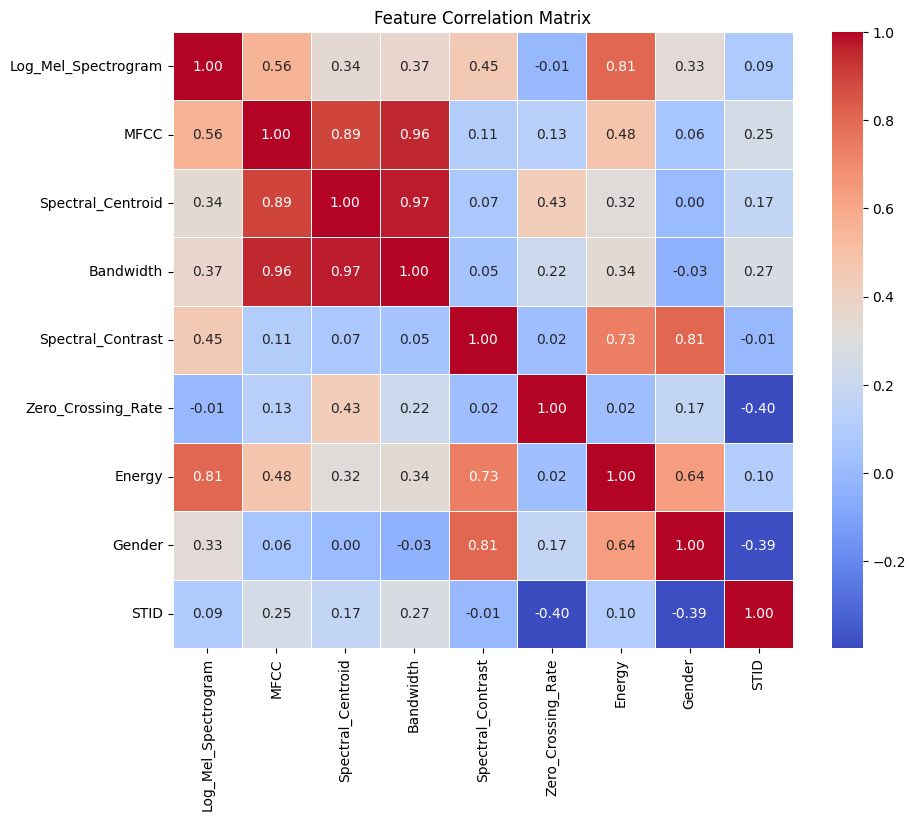

In [ ]:
for col in df_identity1.columns:
    if df_identity1[col].dtype == 'object':
        df_identity1[col] = df_identity1[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)

correlation_matrix = df_identity1.corr()
correlation_with_gender = correlation_matrix["Gender"].drop("Gender")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

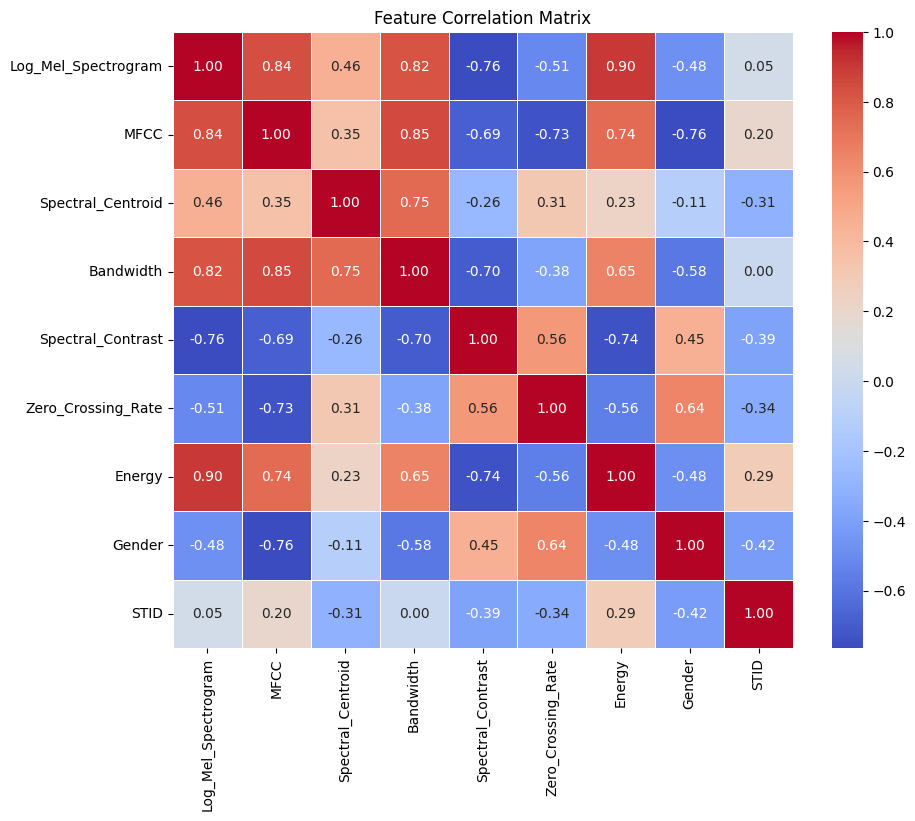

In [ ]:
for col in df_identity2.columns:
    if df_identity2[col].dtype == 'object':
        df_identity2[col] = df_identity2[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)

correlation_matrix = df_identity2.corr()
correlation_with_gender = correlation_matrix["Gender"].drop("Gender")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

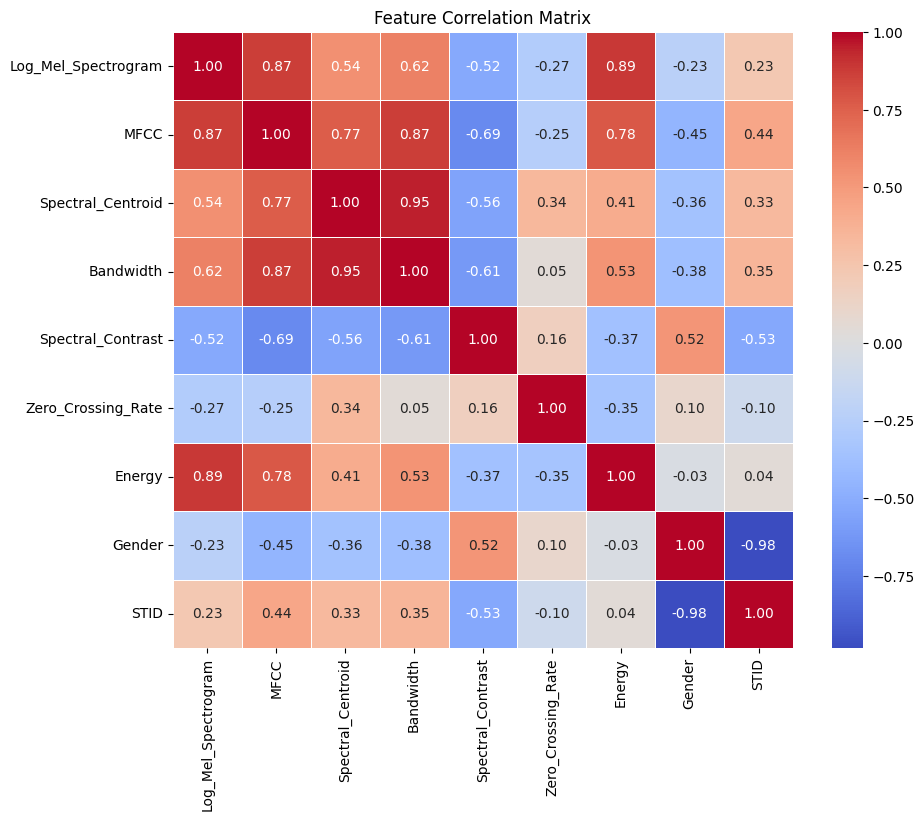

In [ ]:
for col in df_identity3.columns:
    if df_identity3[col].dtype == 'object':
        df_identity3[col] = df_identity3[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)

correlation_matrix = df_identity3.corr()
correlation_with_gender = correlation_matrix["Gender"].drop("Gender")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
def replace_intro(value):
    try:
        # Attempt to convert to string to handle mixed data types
        value_str = str(value).strip() #Remove whitespace
        return 0 if (value_str.lower() == 'intro' or value_str.lower() == 'q1' or value_str.lower() == 'q2' or value_str.lower() == 'q3'
        or value_str.lower() == 'q4' or value_str.lower() == 'q5' or value_str.lower() == 'q6') else value #Case-insensitive comparison
    except:
        return value # If conversion fails (e.g., non-string), keep original value


df_gender = df_gender.map(replace_intro)


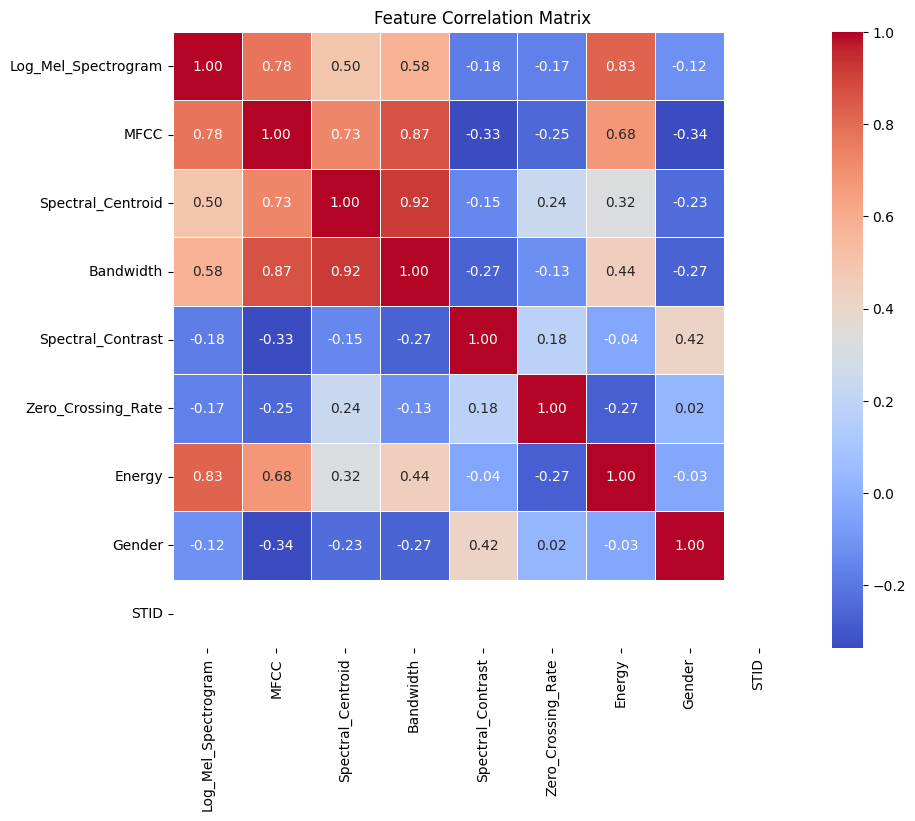

In [ ]:
for col in df_gender.columns:
    if df_gender[col].dtype == 'object':
        df_gender[col] = df_gender[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)

correlation_matrix = df_gender.corr()
correlation_with_gender = correlation_matrix["Gender"].drop("Gender")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

## Multiply the most effective features

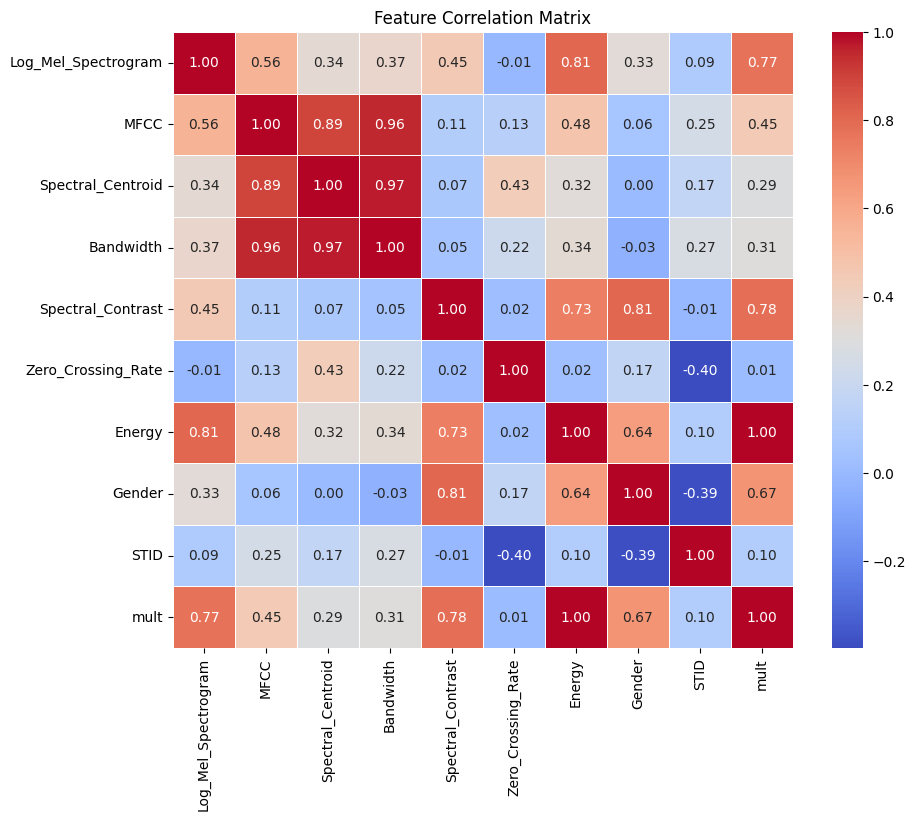

In [ ]:
df_identity1["mult"] = df_identity1["Spectral_Contrast"] * df_identity1["Energy"]
correlation_matrix = df_identity1.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

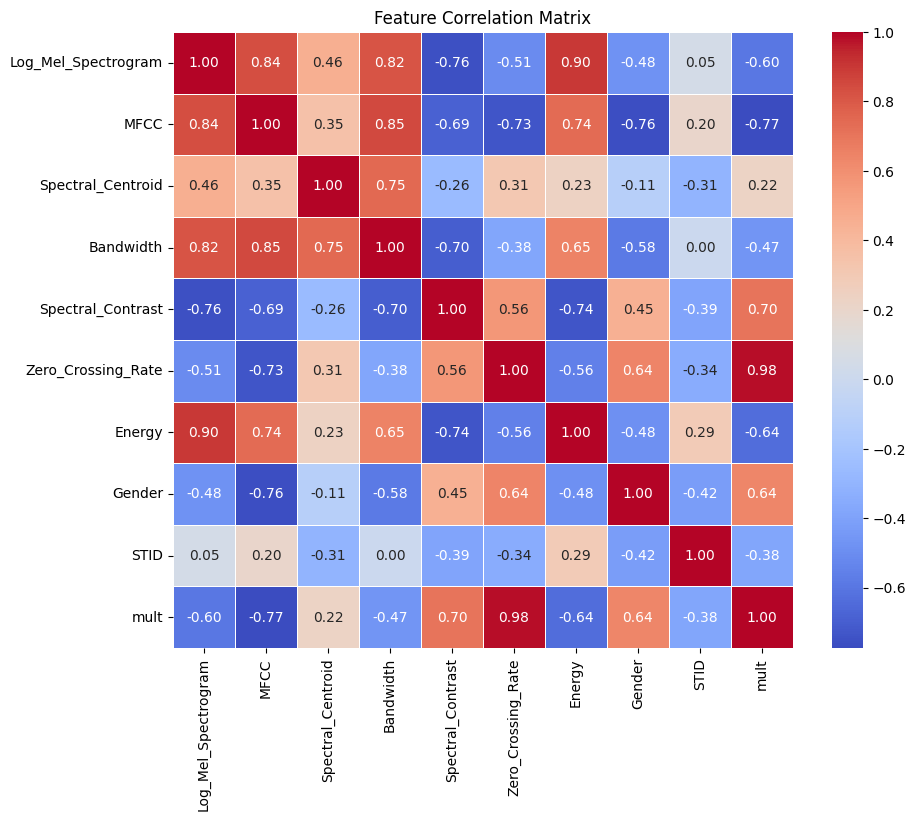

In [ ]:
df_identity2["mult"] = df_identity2["Spectral_Contrast"] * df_identity2["Zero_Crossing_Rate"]
correlation_matrix = df_identity2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

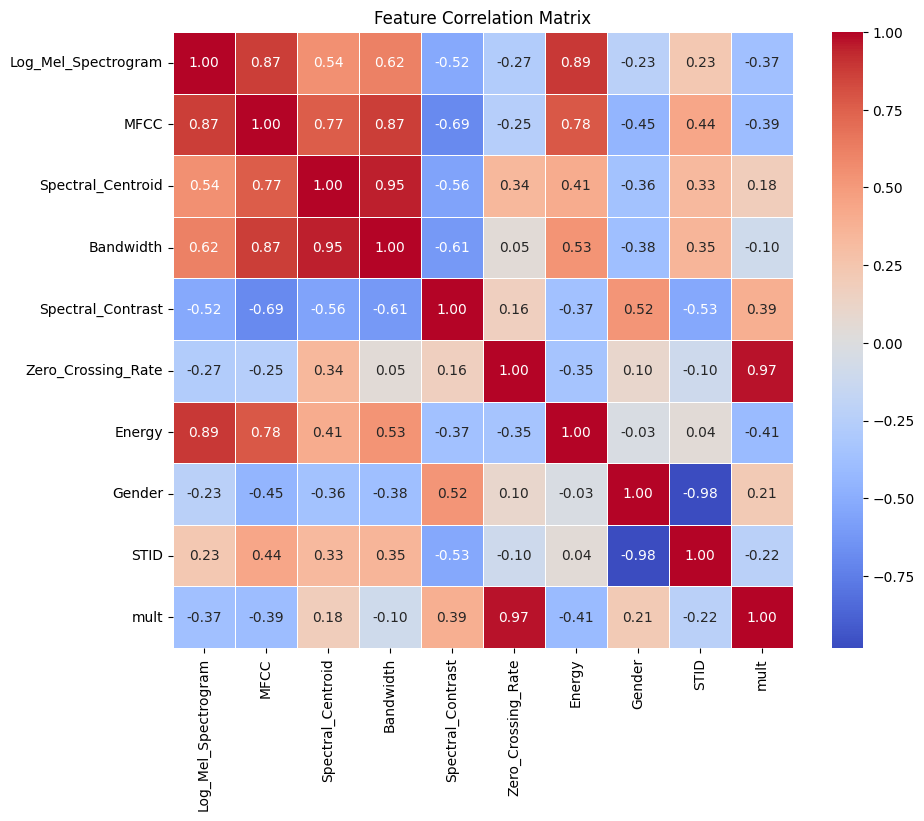

In [ ]:
df_identity3["mult"] = df_identity3["Spectral_Contrast"] * df_identity3["Zero_Crossing_Rate"]
correlation_matrix = df_identity3.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

## Encode student id

In [ ]:
df_identity1['id'], _ = pd.factorize(df_identity1['STID'])
df_identity1 = df_identity1.drop(columns=['STID'])
df_identity1

Log_Mel_Spectrogram       MFCC  Spectral_Centroid    Bandwidth  \
0            -31.329070 -34.433218         959.431630   747.019561   
1            -29.601908 -32.197572        1083.270853   809.046399   
2            -28.612330 -31.966869         967.154661   759.277793   
3            -30.236470 -33.344300        1036.169844   772.820384   
4            -31.078236 -33.471657        1004.957474   732.702344   
5            -29.116251 -32.240628        1107.063508   843.440461   
6            -29.727754 -32.152841        1043.838227   801.898679   
7            -30.555500 -16.939999        1735.266790  2264.690042   
8            -30.818607 -19.233486        1938.130426  2643.147040   
9            -33.286488 -21.394291        1902.863728  2612.412137   
10           -35.201746 -38.521562        1155.269591   743.665628   
11           -28.727554  -9.060782        2178.925297  2872.393098   
12           -29.138613 -15.657375        2128.036306  2787.475175   
13           -34.484745 -21.350460        2078.819437  2615.608015   
14           -33.788895 -36.869430        1114.699895   778.190114   
15           -33.010336 -35.740664        1259.064315   870.010768   
16           -30.641937 -34.349897        1186.503645   842.456063   
17           -34.362432 -36.724546        1233.291018   840.522600   
18           -35.675577 -37.556434        1133.796022   785.100590   
19           -33.130687 -35.876562        1297.678457   861.755687   
20           -27.691410 -31.009305        1288.319029   852.694276   
21           -29.269541 -13.114173        1776.771688  2622.252953   
22           -29.954342 -12.777695        1964.748885  2708.419167   
23           -28.534445  -8.799824        1917.906876  2960.722315   
24           -30.288479 -12.888002        1919.095792  2781.204539   
25           -30.056934 -12.921104        1986.208850  2766.755668   
26           -34.501877 -16.952236        1694.872146  2517.338031   
27           -37.120117 -37.944049        1077.107026   819.181189   
28           -38.081167 -39.256167        1127.721206   800.664467   
29           -35.840182 -36.191663        1031.598023   780.903696   
30           -36.787771 -37.681130        1056.620238   781.992873   
31           -37.913277 -38.917865        1064.502572   797.938142   
32           -35.952405 -38.558711        1247.394511   886.716669   
33           -33.726650 -35.769733        1184.116079   863.755517   
34           -31.178561 -36.495266        1194.183591   836.289277   
35           -32.255711 -36.922549        1255.794623   888.159450   
36           -31.183949 -36.453872        1152.187659   815.153339   
37           -32.837048 -37.983992        1190.911957   895.036666   
38           -33.529693 -38.010583        1172.081978   860.749430   
39           -33.980248 -40.084204        1353.498722   915.967574   
40           -30.938516 -35.820355        1123.232988   829.716624   
41           -34.225535 -40.951641        1279.165603   931.810662   

    Spectral_Contrast  Zero_Crossing_Rate    Energy  Gender  id  
0           23.162315            0.032430  0.089498       1   0  
1           23.818447            0.037752  0.093794       1   0  
2           24.256841            0.031868  0.122557       1   0  
3           23.655880            0.035957  0.091743       1   0  
4           22.905368            0.036042  0.081256       1   0  
5           22.269527            0.039705  0.084402       1   0  
6           24.182528            0.035681  0.102258       1   0  
7           23.685460            0.043969  0.115550       1   1  
8           24.177649            0.039152  0.101492       1   1  
9           23.755614            0.042410  0.080150       1   1  
10          23.278599            0.042054  0.072114       1   1  
11          23.504716            0.049179  0.087402       1   1  
12          23.550043            0.044069  0.131722       1   1  
13          23.347911            0.046503  0.068384       1   1  
14 

In [ ]:
df_identity2['id'], _ = pd.factorize(df_identity2['STID'])
df_identity2 = df_identity2.drop(columns=['STID'])
df_identity2

Log_Mel_Spectrogram       MFCC  Spectral_Centroid    Bandwidth  \
0            -22.458551   0.620615        1564.855827  2532.992292   
1            -26.117710  -4.444457        1615.051038  2781.939983   
2            -21.979837  -1.031582        1415.490803  2448.552643   
3            -23.958893  -0.394464        1234.589064  2144.589137   
4            -22.106632  -1.639786        1625.074497  2574.549383   
5            -24.102520  -2.081399        1406.174550  2361.654604   
6            -20.683252   0.792024        1779.733488  2726.274533   
7            -30.013893 -11.695457         955.730065  1260.001237   
8            -29.576054  -5.991384         974.338240  1328.715599   
9            -29.509279  -5.850065        1154.970751  1438.094517   
10           -31.138136  -8.644196        1011.831218  1383.598801   
11           -29.486900  -7.886601        1135.763002  1409.816077   
12           -27.951502  -9.189133        1149.156099  1359.146924   
13           -28.703522  -9.158737        1190.795988  1489.315088   
14           -36.851519 -41.893062        1405.780597   943.946434   
15           -37.625280 -41.826771        1374.368767   913.654877   
16           -34.362725 -37.808081        1199.568565   892.885864   
17           -28.197504 -32.281341        1193.638938   871.704743   
18           -28.650131 -13.376756        2034.781190  2542.608347   
19           -29.989284 -33.941006        1181.357807   856.661939   
20           -27.969009 -14.321703        2090.337518  2522.236843   
21           -30.970612 -33.460628        1218.600912   908.936843   
22           -31.775414 -34.950133        1217.665363   899.724679   
23           -30.233091 -33.776489        1246.302463   892.634879   
24           -30.496292 -32.838278         991.289450   785.815165   
25           -31.115482 -33.514394        1142.587962   818.451625   
26           -31.509688 -33.061445        1134.565929   839.737990   
27           -30.104262 -32.907697        1217.589732   832.453264   
28           -32.221477 -34.154568        1280.300767   911.412126   
29           -31.429414 -34.151904        1304.154792   889.390387   
30           -34.462859 -34.797687        1183.232832   872.517316   
31           -34.385511 -34.801702        1147.200841   831.661613   
32           -35.918881 -37.739435        1000.181052   747.338116   
33           -32.171644 -34.855091        1284.275562   895.312726   
34           -29.930085 -34.731161        1153.692427   766.811460   
35           -33.127406 -34.909310         937.626448   693.106720   
36           -33.844417 -35.611706        1155.277576   830.563560   

    Spectral_Contrast  Zero_Crossing_Rate    Energy  Gender      mult  id  
0           20.503101            0.030412  0.153959       0  0.623547   0  
1           19.955632            0.027446  0.081679       0  0.547693   0  
2           19.873970            0.026864  0.146480       0  0.533904   0  
3           20.636044            0.023905  0.163238       0  0.493307   0  
4           19.562393            0.031274  0.138789       0  0.611787   0  
5           19.764852            0.027493  0.126330       0  0.543390   0  
6           19.706349            0.037003  0.164318       0  0.729186   0  
7           22.922051            0.023653  0.093382       0  0.542178   1  
8           22.761043            0.020600  0.094668       0  0.468887   1  
9           21.999714            0.029939  0.079952       0  0.658658   1  
10          22.542489            0.024369  0.084801       0  0.549331   1  
11          23.183242            0.028807  0.076671       0  0.667828   1  
12          23.426106            0.029496  0.104890       0  0.690986   1  
13          23.365505            0.031388  0.094517       0  0.733403   1  
14          24.040314            0.049449  0.040573       0  1.188766   2  
15          25.339005            0.049423  0.041413       0  1.252324   2  
16          23.159694            0.039435  0.043534

In [ ]:
df_identity3['id'], _ = pd.factorize(df_identity3['STID'])
df_identity3 = df_identity3.drop(columns=['STID'])
df_identity3

Log_Mel_Spectrogram       MFCC  Spectral_Centroid    Bandwidth  \
0            -34.400976 -37.324101        1124.330606   781.252528   
1            -32.210794 -34.831759        1069.015950   765.044446   
2            -35.644331 -38.592241        1167.997072   791.982408   
3            -33.904268 -37.115881        1143.382917   781.190183   
4            -34.830197 -36.810926        1066.801608   747.946934   
5            -37.553242 -23.881733        2464.423774  3795.374236   
6            -33.286751 -36.666505        1165.447942   838.566528   
7            -31.324104 -35.708393        1215.664578   853.497849   
8            -32.232084 -36.407803        1229.866186   888.952512   
9            -31.552263 -36.845547        1279.658432   904.910324   
10           -29.324739 -35.400602        1319.983784   888.378431   
11           -30.727302 -35.748142        1237.525009   885.041862   
12           -32.777756 -37.247839        1163.767298   850.160854   
13           -32.512446 -36.487573        1154.840033   852.587278   
14           -34.702635 -37.457144        1226.254196   848.210113   
15           -32.789059 -34.736070        1167.342525   879.370274   
16           -33.280504 -35.141693        1275.540736   912.077726   
17           -31.713920 -34.915962        1220.530956   857.108179   
18           -30.008537 -32.088263        1103.635254   843.644066   
19           -29.570122 -32.499840        1147.441656   874.796427   
20           -33.698423 -35.969321        1109.051113   840.256161   
21           -26.632645  -3.121717        1290.276100  2194.504670   
22           -26.077934  -6.591180        2067.223955  2568.083165   
23           -27.248037  -8.866537        1988.709242  2614.181632   
24           -24.608217  -5.898782        2034.763840  2633.127759   
25           -24.429087  -6.043766        1901.982848  2621.239653   
26           -22.975819  -0.405141        1489.009786  2319.088025   
27           -25.376730  -6.253771        1819.614972  2482.484139   
28           -38.793040 -40.520060        1181.136546   814.996511   
29           -35.647698 -37.488386        1154.447493   807.859591   
30           -37.483458 -39.166312        1187.115614   825.022031   
31           -34.504888 -37.475441        1203.194025   840.977561   
32           -35.792551 -37.657809        1075.803364   764.719952   
33           -35.865836 -37.214043        1218.876197   829.311183   
34           -37.866610 -40.497123        1122.341799   797.440488   
35           -35.365398 -39.100742        1300.348395   935.009709   
36           -35.519886 -39.345024        1399.289744  1004.272986   
37           -23.244801  -1.175723        1974.541526  2429.783985   
38           -32.093277 -35.429006        1108.023377   876.450121   
39           -24.227089  -1.295785        1890.838451  2505.996737   
40           -32.930426 -38.347536        1339.462856   943.042387   

    Spectral_Contrast  Zero_Crossing_Rate    Energy  Gender      mult  id  
0           22.869572            0.039104  0.059399       1  0.894280   0  
1           22.533080            0.037551  0.085584       1  0.846139   0  
2           23.513011            0.042096  0.058754       1  0.989810   0  
3           23.055994            0.040563  0.068559       1  0.935217   0  
4           22.480916            0.037849  0.061887       1  0.850871   0  
5           22.700774            0.049403  0.046365       1  1.121481   0  
6           23.208198            0.039581  0.055663       1  0.918613   0  
7           23.323985            0.039834  0.070842       1  0.929076   1  
8           23.428553            0.039228  0.056336       1  0.919056   1  
9           23.642640            0.042291  0.062150       1  0.999864   1  
10          24.064694            0.045917  0.083377       1  1.104971   1  
11          23.239450            0.040742  0.076222       1  0.946833   1  
12          23.797705            0.037322  0.064186       1  0.888177   1  

## Plot features

In [ ]:
def plot_spectrogram(y, sr):
    D = np.abs(librosa.stft(y))
    D_db = librosa.amplitude_to_db(D, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

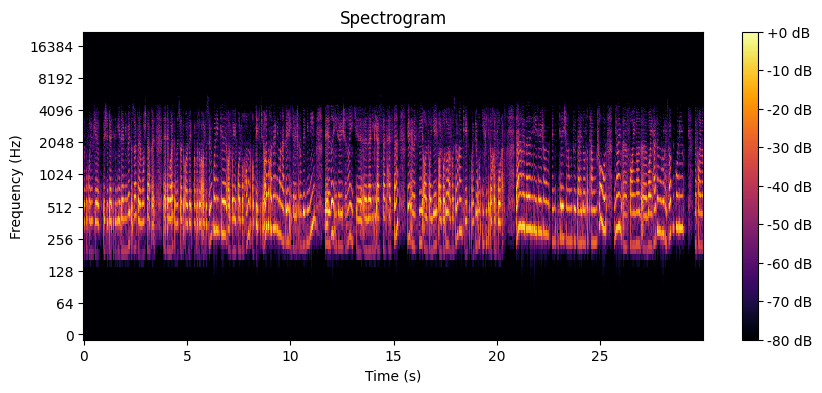

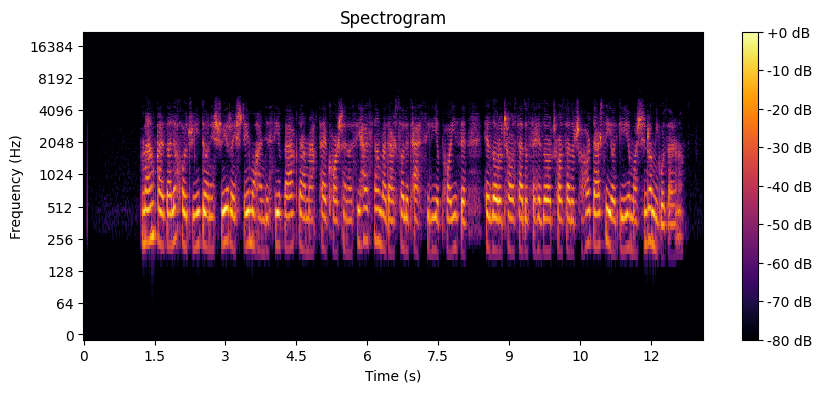

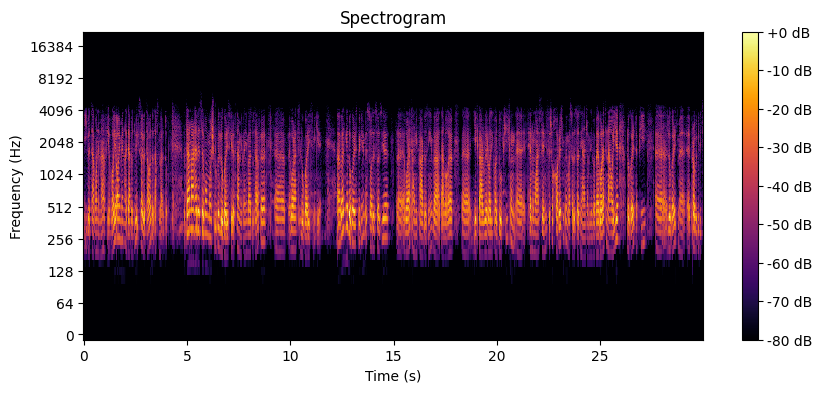

In [ ]:
index = 0
for file, (y, sr) in audio_data_identity1.items():
    if index % 20 == 0:
      plot_spectrogram(y, sr)
    index += 1

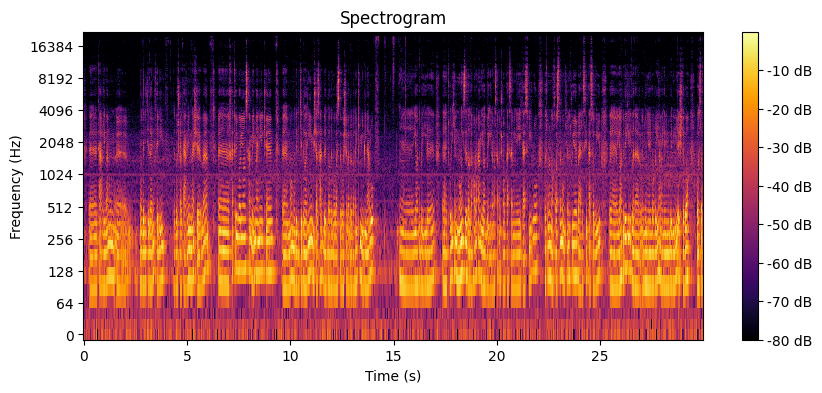

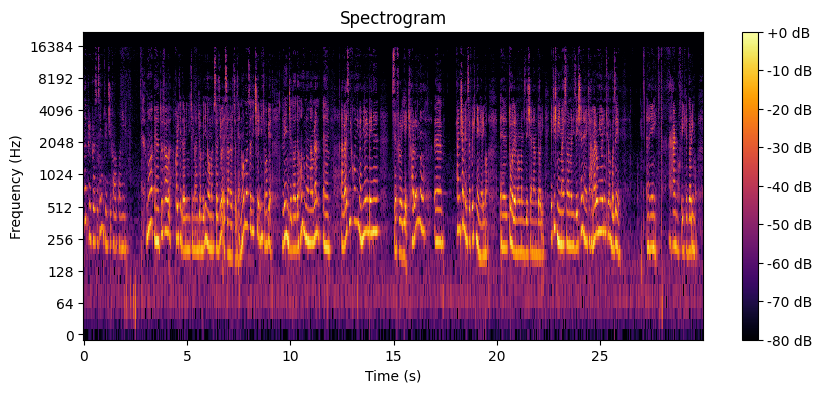

In [ ]:
index = 0
for file, (y, sr) in audio_data_identity2.items():
    if index % 20 == 0:
      plot_spectrogram(y, sr)
    index += 1

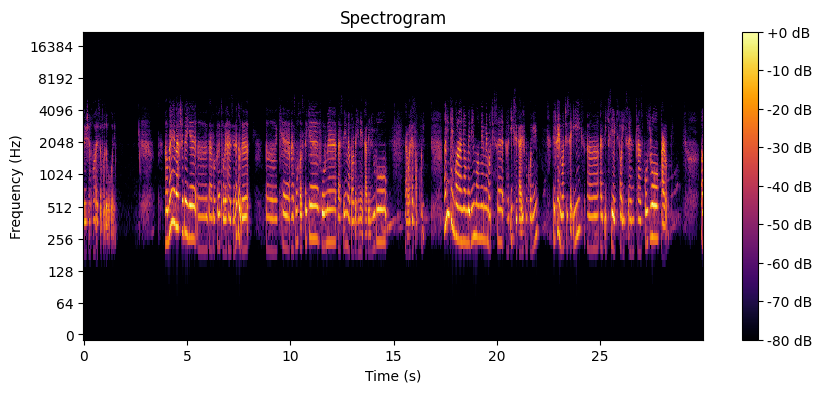

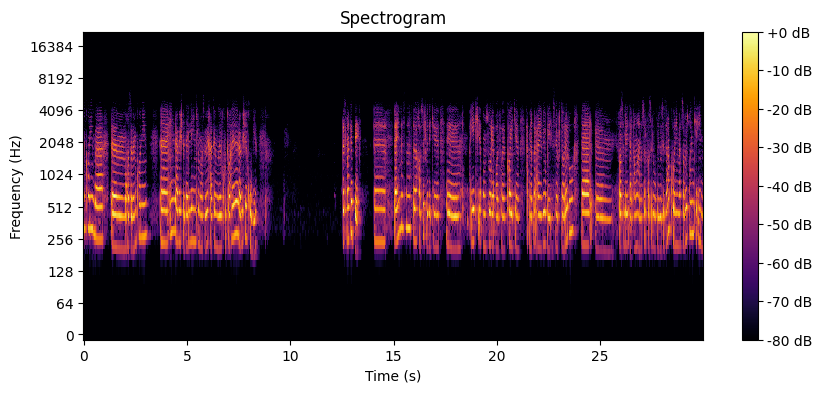

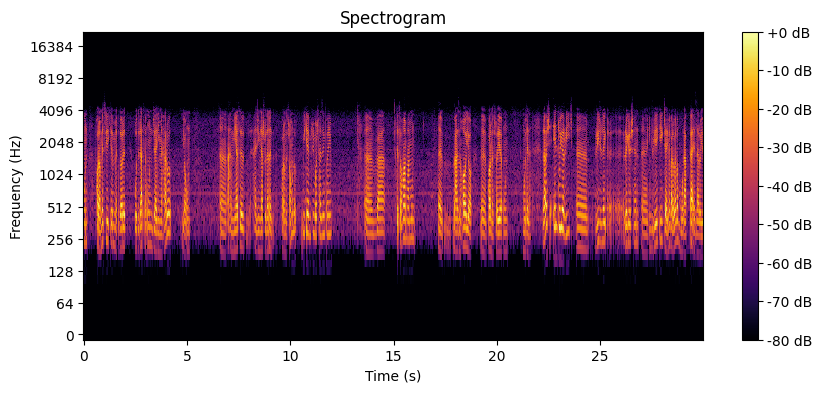

In [ ]:
index = 0
for file, (y, sr) in audio_data_identity3.items():
    if index % 20 == 0:
      plot_spectrogram(y, sr)
    index += 1

In [ ]:
index = 0
for file, (y, sr) in audio_data_gender.items():
    if index % 20 == 0:
      plot_spectrogram(y, sr)
    index += 1

Output hidden; open in https://colab.research.google.com to view.

## Flatten data

In [ ]:
def flatten_features(df):
    new_df = df.copy()
    for col in df.columns:
        if isinstance(df[col][0], np.ndarray):
            arr_shape = df[col][0].shape
            if len(arr_shape) == 1:
                for i in range(arr_shape[0]):
                    new_df[f"{col}_{i}"] = df[col].apply(lambda x: x[i] if len(x) > i else 0)
            else:
                new_df[f"{col}_mean"] = df[col].apply(lambda x: np.mean(x))
                new_df[f"{col}_std"] = df[col].apply(lambda x: np.std(x))
                new_df[f"{col}_max"] = df[col].apply(lambda x: np.max(x))
            new_df.drop(columns=[col], inplace=True)
    return new_df

# Supervised

## Logistic regression (gender)

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69        25
           1       0.75      0.77      0.76        31

    accuracy                           0.73        56
   macro avg       0.73      0.73      0.73        56
weighted avg       0.73      0.73      0.73        56

Confusion Matrix:
[[17  8]
 [ 7 24]]


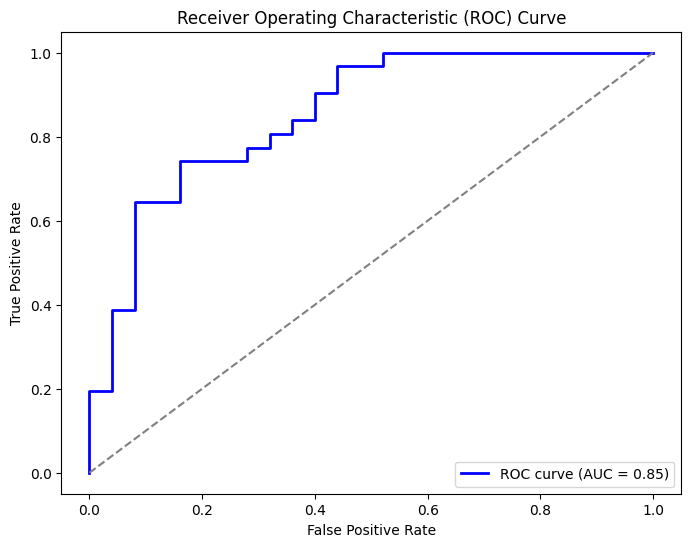

In [ ]:
df = flatten_features(df_gender)
X = df.drop(columns=['Gender'])
y = df['Gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

y_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## KNN (gender)

KNN Results:
              precision    recall  f1-score   support

           0       0.73      0.64      0.68        25
           1       0.74      0.81      0.77        31

    accuracy                           0.73        56
   macro avg       0.73      0.72      0.73        56
weighted avg       0.73      0.73      0.73        56

Confusion Matrix:
[[16  9]
 [ 6 25]]


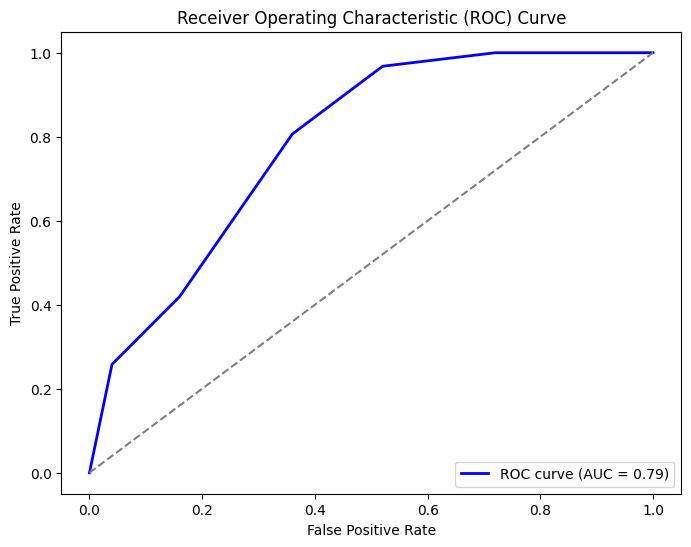

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN Results:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))
y_prob = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## SVM (gender)

Model Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.94      0.57      0.71        28
           1       0.69      0.96      0.81        28

    accuracy                           0.77        56
   macro avg       0.82      0.77      0.76        56
weighted avg       0.82      0.77      0.76        56

Confusion Matrix:
[[16 12]
 [ 1 27]]


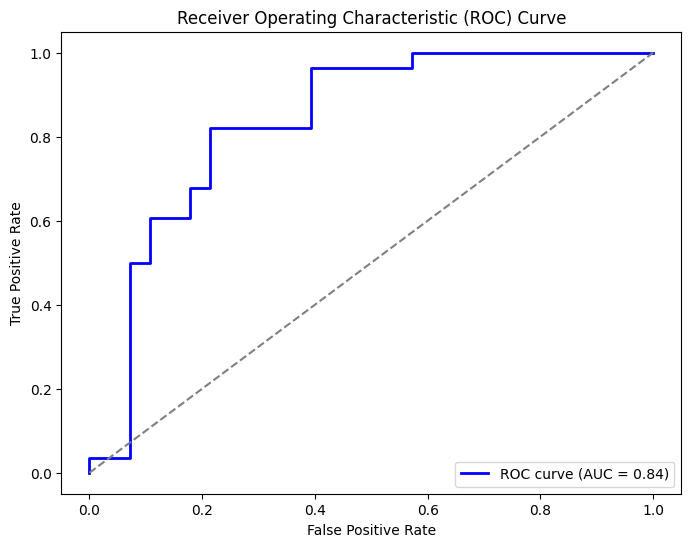

In [ ]:
X = df.drop(columns=['Gender'])
y = df['Gender']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Logistic regreession (identity)

In [ ]:
def split_identity(df3):
    df = df3.copy()
    df['idx'] = df.index
    df['idx'] = df['idx'].apply(lambda x: 1 if x % 7 == 0 else 0)
    df1 = df[df['idx'] == 0]
    df2 = df[df['idx'] != 0]
    df1 = df1.drop(columns=['idx']).reset_index().drop(columns=["index"])
    df2 = df2.drop(columns=['idx']).reset_index().drop(columns=["index"])
    return [df1, df2]

In [ ]:
trainn, testt = split_identity(df3 = df_identity1)
X_train = trainn[[col for col in trainn.columns if col != 'id']]
X_test = testt[[col for col in testt.columns if col != 'id']]
y_train = trainn[['id']]
y_test = testt[['id']]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Confusion Matrix:
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
trainn, testt = split_identity(df3 = df_identity2)
X_train = trainn[[col for col in trainn.columns if col != 'id']]
X_test = testt[[col for col in testt.columns if col != 'id']]
y_train = trainn[['id']]
y_test = testt[['id']]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Confusion Matrix:
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
trainn, testt = split_identity(df3 = df_identity3)
X_train = trainn[[col for col in trainn.columns if col != 'id']]
X_test = testt[[col for col in testt.columns if col != 'id']]
y_train = trainn[['id']]
y_test = testt[['id']]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1

    accuracy                           0.67         6
   macro avg       0.50      0.67      0.56         6
weighted avg       0.50      0.67      0.56         6

Confusion Matrix:
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning

## KNN (indentity)

In [ ]:
trainn, testt = split_identity(df3 = df_identity1)
X_train = trainn[[col for col in trainn.columns if col != 'id']]
X_test = testt[[col for col in testt.columns if col != 'id']]
y_train = trainn[['id']]
y_test = testt[['id']]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN Results:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

KNN Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Confusion Matrix:
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
trainn, testt = split_identity(df3 = df_identity2)
X_train = trainn[[col for col in trainn.columns if col != 'id']]
X_test = testt[[col for col in testt.columns if col != 'id']]
y_train = trainn[['id']]
y_test = testt[['id']]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN Results:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

KNN Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       0.50      1.00      0.67         1
           5       0.00      0.00      0.00         1

    accuracy                           0.67         6
   macro avg       0.58      0.67      0.61         6
weighted avg       0.58      0.67      0.61         6

Confusion Matrix:
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

In [ ]:
trainn, testt = split_identity(df3 = df_identity3)
X_train = trainn[[col for col in trainn.columns if col != 'id']]
X_test = testt[[col for col in testt.columns if col != 'id']]
y_train = trainn[['id']]
y_test = testt[['id']]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN Results:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

KNN Results:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1

    accuracy                           0.67         6
   macro avg       0.50      0.67      0.56         6
weighted avg       0.50      0.67      0.56         6

Confusion Matrix:
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

## SVM (identity)

In [ ]:
trainn, testt = split_identity(df3=df_identity1)
X_train = trainn[[col for col in trainn.columns if col != 'id']]
X_test = testt[[col for col in testt.columns if col != 'id']]
y_train = trainn[['id']]
y_test = testt[['id']]
scaler = StandardScaler()
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Accuracy: 0.83
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1

    accuracy                           0.83         6
   macro avg       0.75      0.83      0.78         6
weighted avg       0.75      0.83      0.78         6

Confusion Matrix:
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
trainn, testt = split_identity(df3=df_identity2)
X_train = trainn[[col for col in trainn.columns if col != 'id']]
X_test = testt[[col for col in testt.columns if col != 'id']]
y_train = trainn[['id']]
y_test = testt[['id']]
scaler = StandardScaler()
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Model Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Confusion Matrix:
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
trainn, testt = split_identity(df3=df_identity3)
X_train = trainn[[col for col in trainn.columns if col != 'id']]
X_test = testt[[col for col in testt.columns if col != 'id']]
y_train = trainn[['id']]
y_test = testt[['id']]
scaler = StandardScaler()
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1

    accuracy                           0.83         6
   macro avg       0.75      0.83      0.78         6
weighted avg       0.75      0.83      0.78         6

Confusion Matrix:
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Unsupervised

##PCA Plot Identity

In [ ]:
X = df_identity1.drop(columns=['id'])
y = df_identity1['id']
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca['id'] = y
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='id',
                    title='PCA of Voice Data (3D)',
                    labels={'PC1': 'First PC', 'PC2': 'Second PC', 'PC3': 'Third PC'},
                    opacity=0.6)
fig.show()

##K_Means Identity

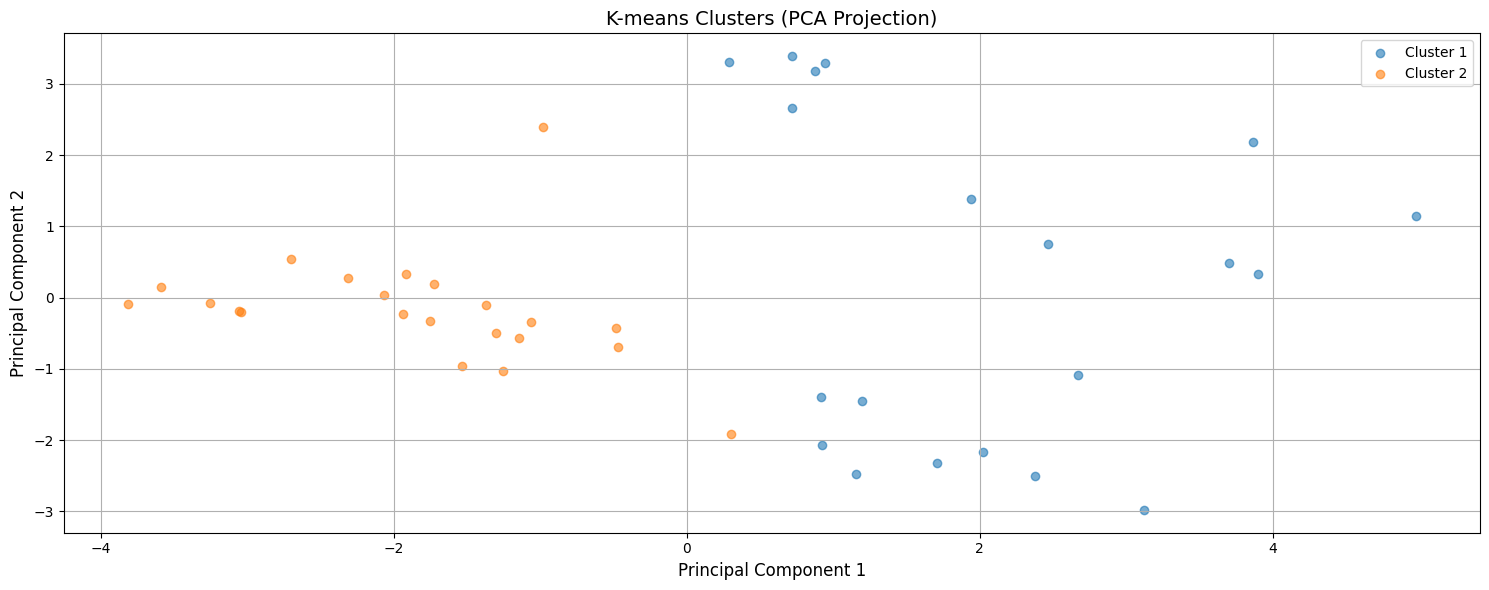

Silhouette Score for K-means clustering: 0.3502710683354807


In [ ]:
X = df_identity1.drop(columns=['id'])
y = df_identity1['id']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_scaled)
df_identity1['cluster'] = kmeans.labels_
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(15, 6))
for cluster in range(k):
    plt.scatter(X_pca[df_identity1['cluster'] == cluster, 0], X_pca[df_identity1['cluster'] == cluster, 1],
                label=f'Cluster {cluster + 1}', alpha=0.6)
plt.title('K-means Clusters (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

kmeans_silhouette = silhouette_score(X_scaled, df_identity1['cluster'])
print(f"Silhouette Score for K-means clustering: {kmeans_silhouette}")

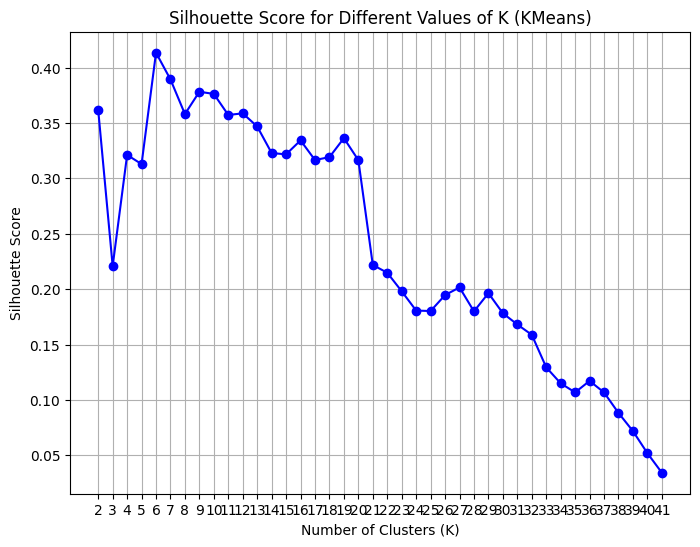

Best K (Number of Clusters) based on Silhouette Score: 6


In [ ]:
sil_scores = []
K_range = range(2, 42)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    try:
        kmeans.fit(X_scaled)
        score = silhouette_score(X_scaled, kmeans.labels_)
        sil_scores.append(score)
    except ValueError as e:
        print(f"Error during clustering with k={k}: {e}")
        sil_scores.append(np.nan)
plt.figure(figsize=(8, 6))
plt.plot(K_range, sil_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Different Values of K (KMeans)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range)
plt.grid(True)
plt.show()
best_k_index = np.nanargmax(sil_scores)
best_K = K_range[best_k_index]
print(f"Best K (Number of Clusters) based on Silhouette Score: {best_K}")

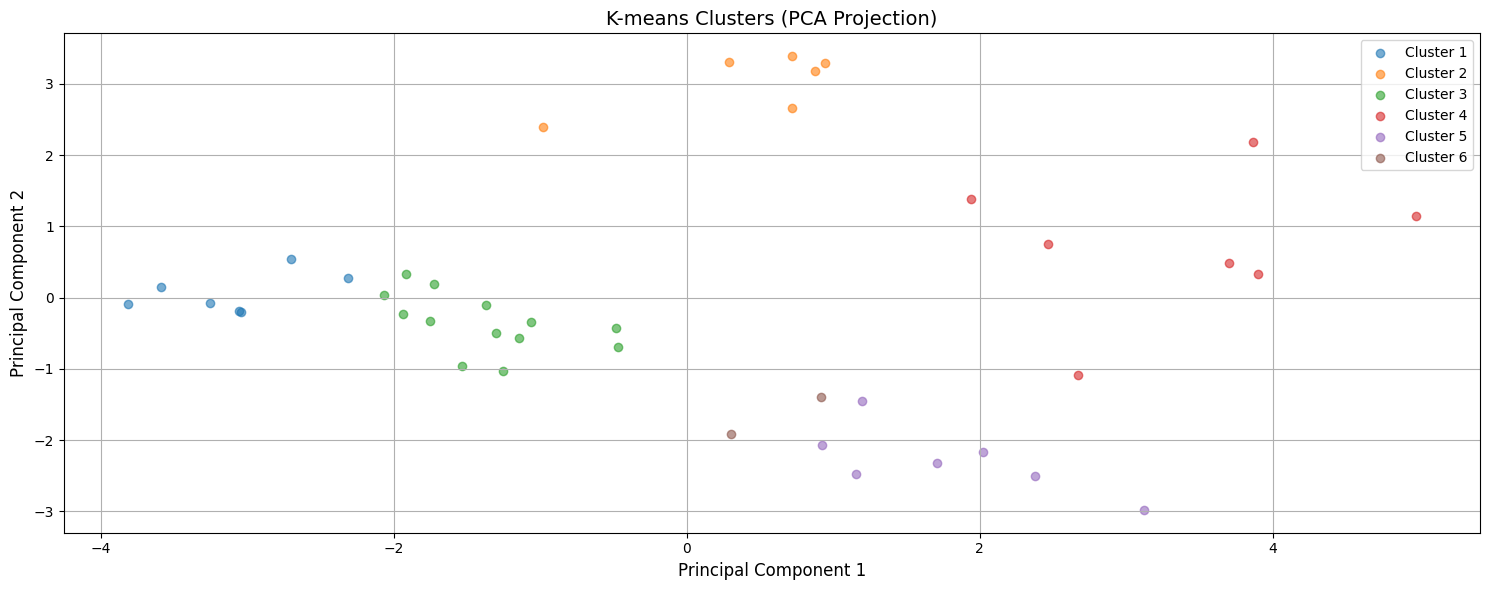

Silhouette Score for K-means clustering: 0.31831727687077


In [ ]:
kmeans = KMeans(n_clusters=best_K)
kmeans.fit(X_scaled)
df_identity1['cluster'] = kmeans.labels_
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(15, 6))
for cluster in range(best_K):
    plt.scatter(X_pca[df_identity1['cluster'] == cluster, 0], X_pca[df_identity1['cluster'] == cluster, 1],
                label=f'Cluster {cluster + 1}', alpha=0.6)
plt.title('K-means Clusters (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

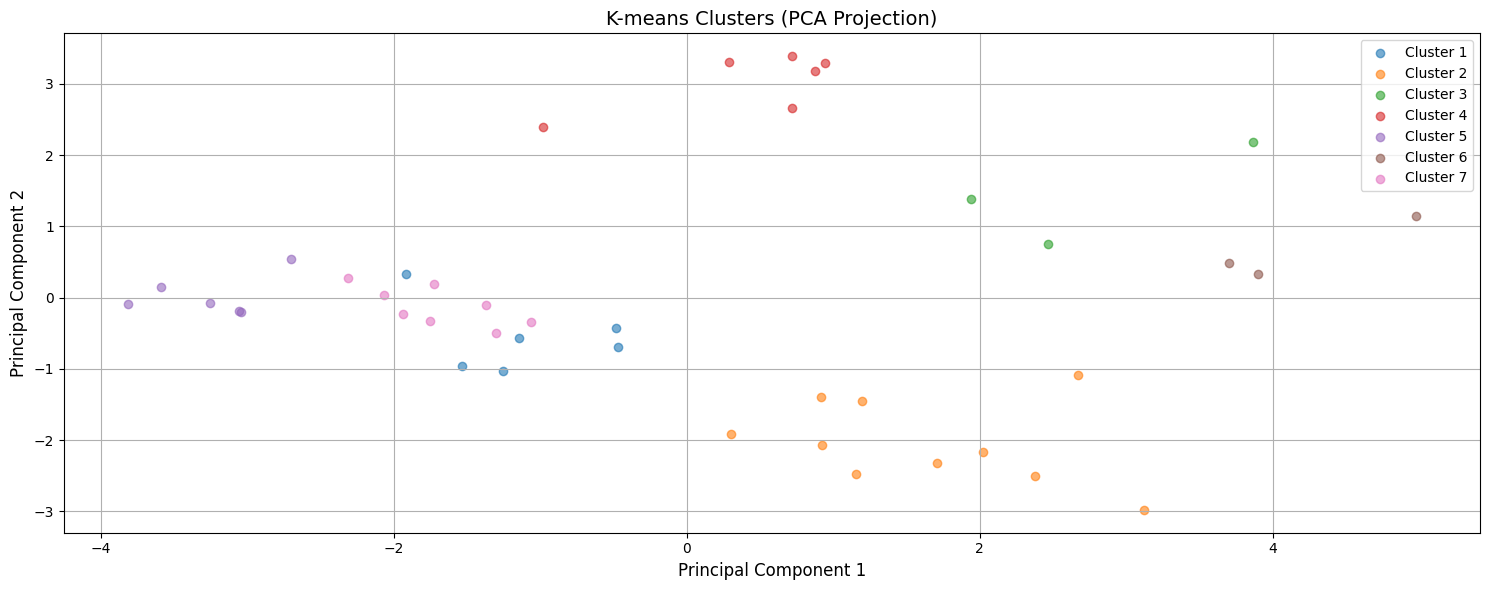

In [ ]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_scaled)
df_identity1['cluster'] = kmeans.labels_
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(15, 6))
for cluster in range(7):
    plt.scatter(X_pca[df_identity1['cluster'] == cluster, 0], X_pca[df_identity1['cluster'] == cluster, 1],
                label=f'Cluster {cluster + 1}', alpha=0.6)
plt.title('K-means Clusters (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

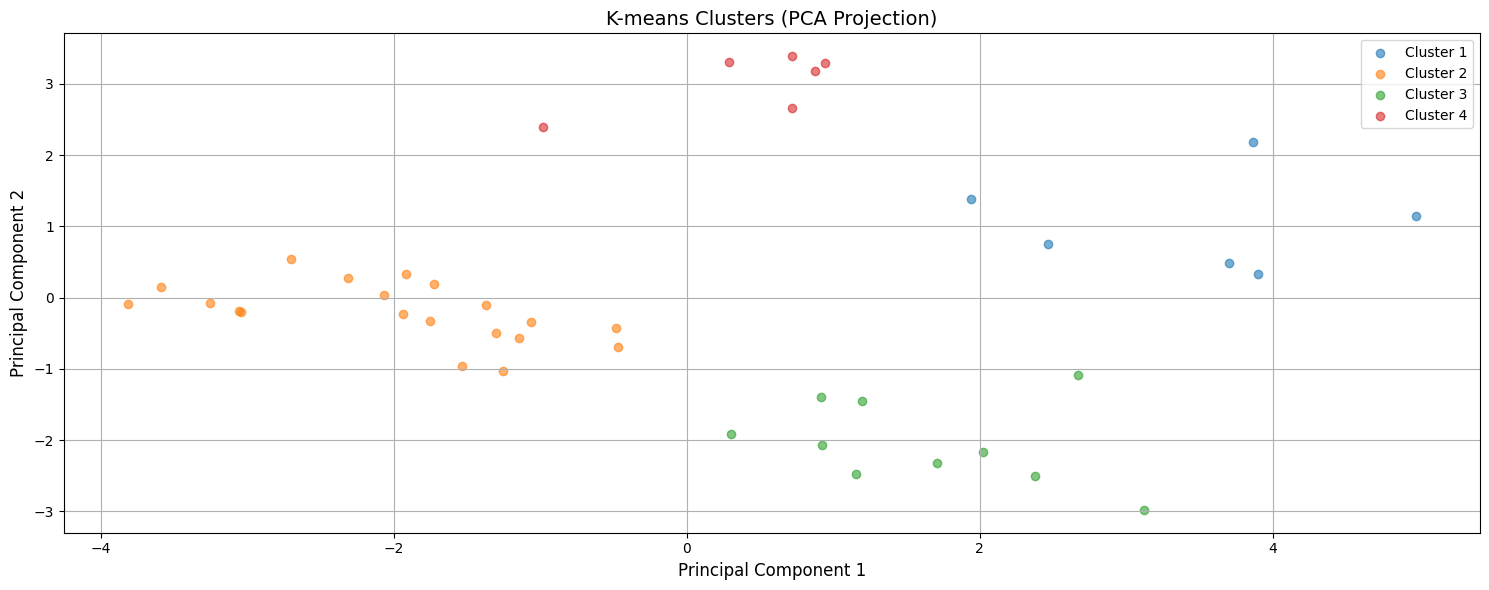

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_scaled)
df_identity1['cluster'] = kmeans.labels_
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(15, 6))
for cluster in range(4):
    plt.scatter(X_pca[df_identity1['cluster'] == cluster, 0], X_pca[df_identity1['cluster'] == cluster, 1],
                label=f'Cluster {cluster + 1}', alpha=0.6)
plt.title('K-means Clusters (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Guassian mixture Identity

In [ ]:
X = df_identity1.drop(columns=['id'])
y = df_identity1['id']
scaler = StandardScaler()
X = scaler.fit_transform(X)

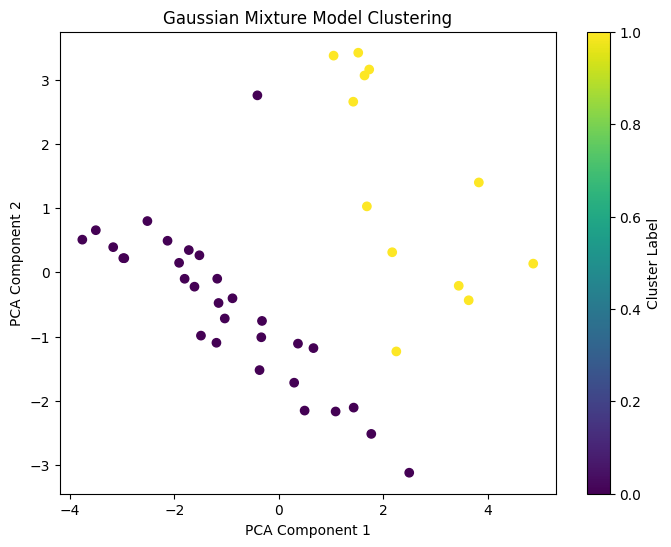

Cluster Centers (means of the Gaussians):
[[-0.30497671 -0.554996   -0.5660306  -0.56207673 -0.08216957 -0.21944612
  -0.31410508 -0.06666673 -0.29166867 -0.01590001]
 [ 0.7624416   1.3874897   1.4150762   1.40519152  0.20542389  0.54861518
   0.78526253  0.16666679  0.72917152  0.03975002]]


In [ ]:
gmm = GaussianMixture(n_components=2)
gmm.fit(X)

labels = gmm.predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()
print("Cluster Centers (means of the Gaussians):")
print(gmm.means_)

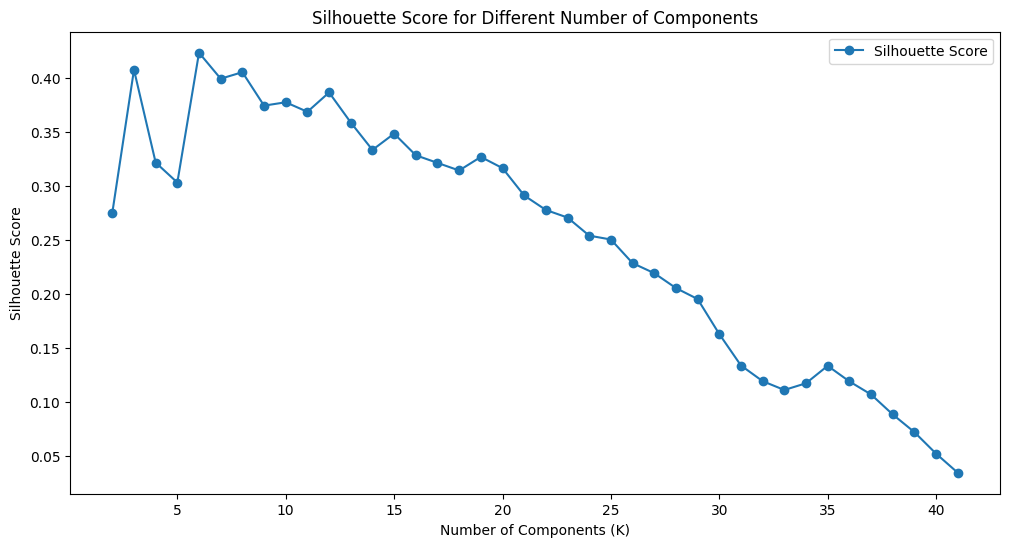

Best number of components (based on Silhouette Score): 6


In [ ]:
X_scaled = X
k_values = range(1, len(df_identity1))
silhouette_scores = []
for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    if k > 1:
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan)
k_values = k_values[1:]
silhouette_scores = [score for score in silhouette_scores if not np.isnan(score)]
plt.figure(figsize=(12, 6))
plt.plot(k_values, silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Score for Different Number of Components')
plt.xlabel('Number of Components (K)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()
best_k_silhouette = k_values[np.argmax(silhouette_scores)]
print(f"Best number of components (based on Silhouette Score): {best_k_silhouette}")

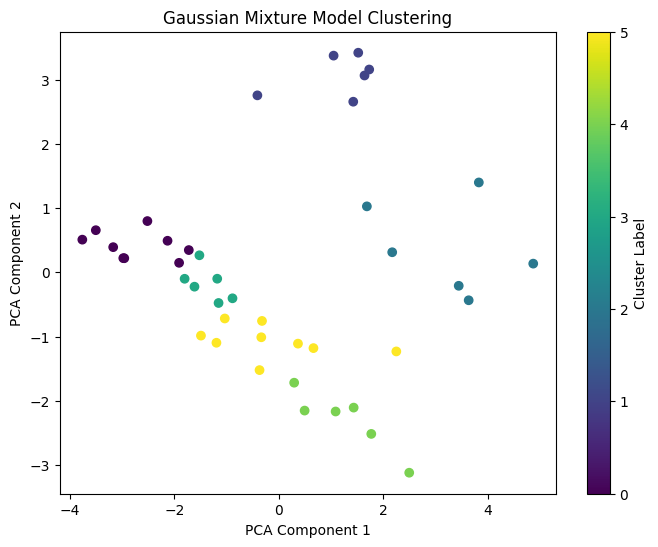

Cluster Centers (means of the Gaussians):
[[-1.30780477e+00 -8.28023925e-01 -5.70313087e-01 -6.07345410e-01
  -1.04019327e+00  3.97317364e-02 -1.16016802e+00 -1.00000000e+00
  -1.13976301e+00 -4.23999152e-01]
 [ 6.89976877e-01  1.72350252e+00  1.34921533e+00  1.62494492e+00
  -1.00489372e+00 -2.65416409e-01  1.07867753e-02 -1.00000000e+00
  -1.30656908e-01  1.80199640e+00]
 [ 4.24423915e-01  1.28623391e+00  1.66192763e+00  1.51416700e+00
   1.27613463e+00  8.74156526e-01  1.12927310e+00  1.00000000e+00
   1.18891885e+00 -1.53699693e+00]
 [ 1.28368315e-01 -6.85234161e-01 -5.07730889e-01 -5.93031461e-01
  -2.54896134e-01 -3.91725690e-01 -5.03548281e-01 -1.00000000e+00
  -5.05809177e-01 -4.23999152e-01]
 [ 8.11717767e-01 -2.82421503e-01 -9.50049934e-01 -6.92231809e-01
   1.26932685e+00 -1.27119611e+00  1.10513618e+00  1.00000000e+00
   1.17174731e+00  6.88998622e-01]
 [-6.18531465e-02 -5.33363249e-01 -4.65261676e-01 -6.28553692e-01
   1.83078850e-01  6.63056050e-01 -9.30497503e-04  1.0000

In [ ]:
gmm = GaussianMixture(n_components=best_k_silhouette)
gmm.fit(X)
labels = gmm.predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()
print("Cluster Centers (means of the Gaussians):")
print(gmm.means_)

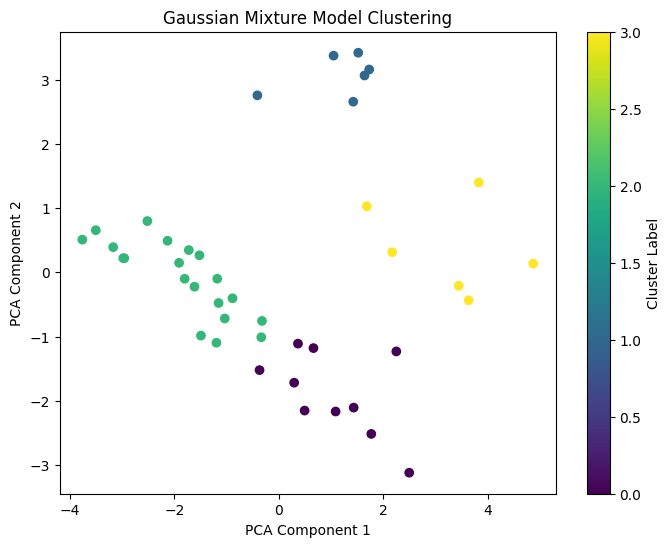

Cluster Centers (means of the Gaussians):
[[ 0.7299585  -0.32661458 -0.77003438 -0.66848568  0.86384359 -0.51681864
   0.93798171  1.          0.95132276  0.68899862]
 [ 0.68997688  1.72350252  1.34921533  1.62494492 -1.00489372 -0.26541641
   0.01078678 -1.         -0.13065691  1.8019964 ]
 [-0.69929949 -0.73961364 -0.5183257  -0.60749074 -0.51329407  0.07578728
  -0.81100882 -0.5        -0.79313996 -0.42399915]
 [ 0.42442392  1.28623391  1.66192763  1.514167    1.27613463  0.87415653
   1.1292731   1.          1.18891885 -1.53699693]]


In [ ]:
gmm = GaussianMixture(n_components=4)
gmm.fit(X)

labels = gmm.predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()
print("Cluster Centers (means of the Gaussians):")
print(gmm.means_)

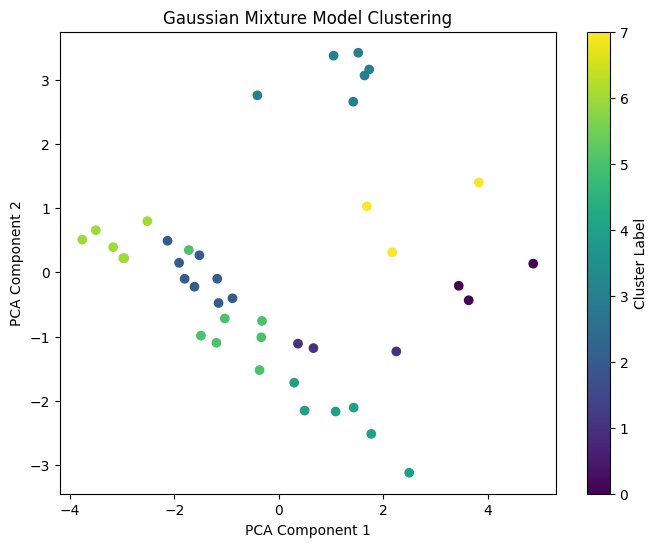

Cluster Centers (means of the Gaussians):
[[ 0.78521775  1.28581095  1.50202959  1.43416901  1.41307138  0.45309347
   1.88707269  1.          1.92844346 -1.53699693]
 [ 1.15446043 -0.24289542 -0.4741733  -0.60249517  0.04870126  0.69512118
   0.88024148  1.          0.77121748  0.68899862]
 [-0.05144011 -0.72062826 -0.47418065 -0.5801168  -0.3750245  -0.19489978
  -0.59467256 -1.         -0.59600919 -0.42399915]
 [ 0.68997688  1.72350252  1.34921533  1.62494492 -1.00489372 -0.26541641
   0.01078678 -1.         -0.13065691  1.8019964 ]
 [ 0.81171777 -0.2824215  -0.95004993 -0.69223181  1.26932685 -1.27119611
   1.10513618  1.          1.17174731  0.68899862]
 [-0.65891824 -0.7244418  -0.40183884 -0.62418921  0.2085642   0.8088914
  -0.52098694  0.71428571 -0.47607683 -0.26499947]
 [-1.66602402 -0.79984743 -0.72295355 -0.64392273 -1.30821062 -0.36894486
  -1.28460195 -1.         -1.26551611 -0.42399915]
 [ 0.06363008  1.28665687  1.82182568  1.59416499  1.13919787  1.29521958
   0.37147

In [ ]:
gmm = GaussianMixture(n_components=8)
gmm.fit(X)

labels = gmm.predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()
print("Cluster Centers (means of the Gaussians):")
print(gmm.means_)

## PCA Plot Gender

In [ ]:
X = df_gender.drop(columns=['Gender'])
y = df_gender['Gender']
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca['Gender'] = y
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='Gender',
                    title='PCA of Voice Data (3D)',
                    labels={'PC1': 'First PC', 'PC2': 'Second PC', 'PC3': 'Third PC'},
                    opacity=0.6)
fig.show()

## K-Means Gender

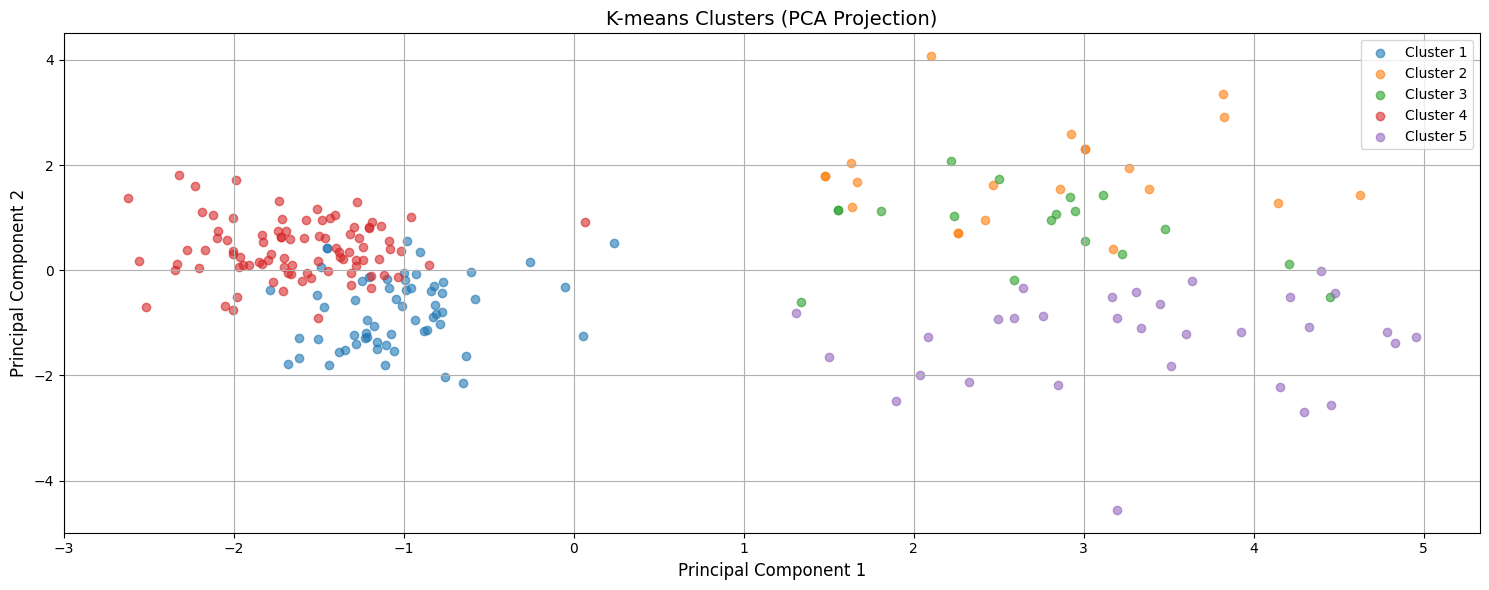

Silhouette Score for K-means clustering: 0.24878811990710686


In [ ]:
X = df_gender.drop(columns=['Gender'])
y = df_gender['Gender']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
k = 5
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_scaled)
df_gender['cluster'] = kmeans.labels_
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(15, 6))
for cluster in range(k):
    plt.scatter(X_pca[df_gender['cluster'] == cluster, 0], X_pca[df_gender['cluster'] == cluster, 1],
                label=f'Cluster {cluster + 1}', alpha=0.6)
plt.title('K-means Clusters (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

kmeans_silhouette = silhouette_score(X_scaled, df_gender['cluster'])
print(f"Silhouette Score for K-means clustering: {kmeans_silhouette}")

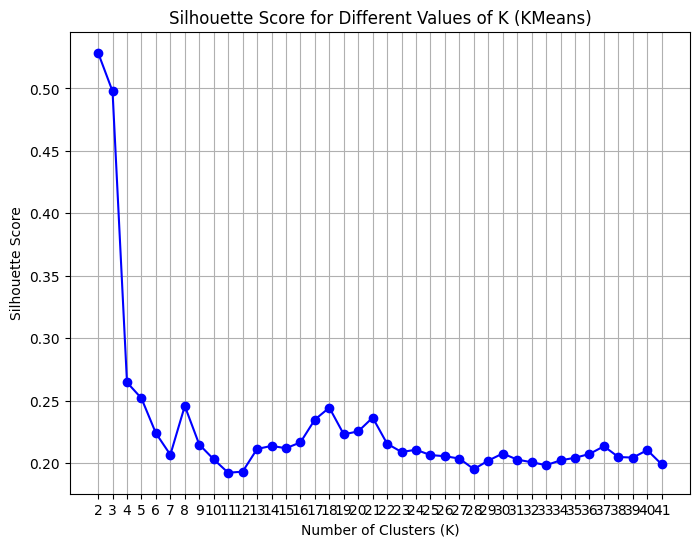

Best K (Number of Clusters) based on Silhouette Score: 2


In [ ]:
sil_scores = []
K_range = range(2, 42)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    try:
        kmeans.fit(X_scaled)
        score = silhouette_score(X_scaled, kmeans.labels_)
        sil_scores.append(score)
    except ValueError as e:
        print(f"Error during clustering with k={k}: {e}")
        sil_scores.append(np.nan)
plt.figure(figsize=(8, 6))
plt.plot(K_range, sil_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Different Values of K (KMeans)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range)
plt.grid(True)
plt.show()
best_k_index = np.nanargmax(sil_scores)
best_K = K_range[best_k_index]
print(f"Best K (Number of Clusters) based on Silhouette Score: {best_K}")

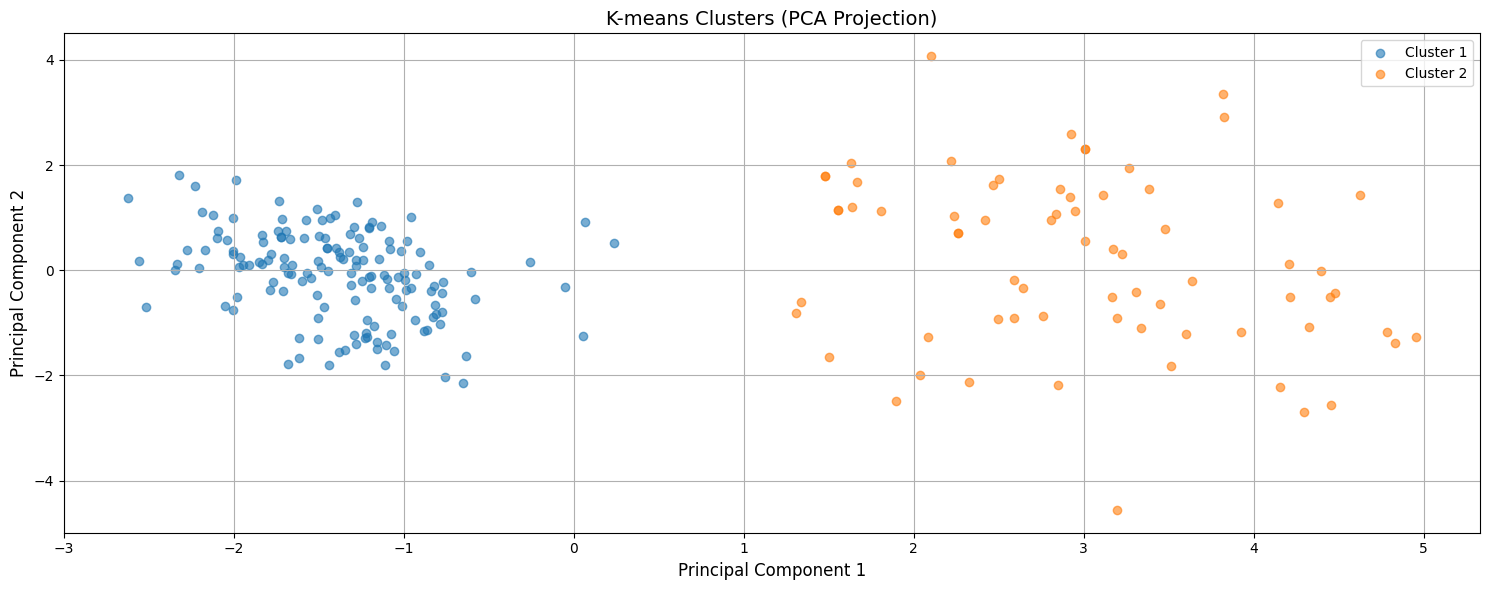

In [ ]:
kmeans = KMeans(n_clusters=best_K)
kmeans.fit(X_scaled)
df_gender['cluster'] = kmeans.labels_
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(15, 6))
for cluster in range(best_K):
    plt.scatter(X_pca[df_gender['cluster'] == cluster, 0], X_pca[df_gender['cluster'] == cluster, 1],
                label=f'Cluster {cluster + 1}', alpha=0.6)
plt.title('K-means Clusters (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

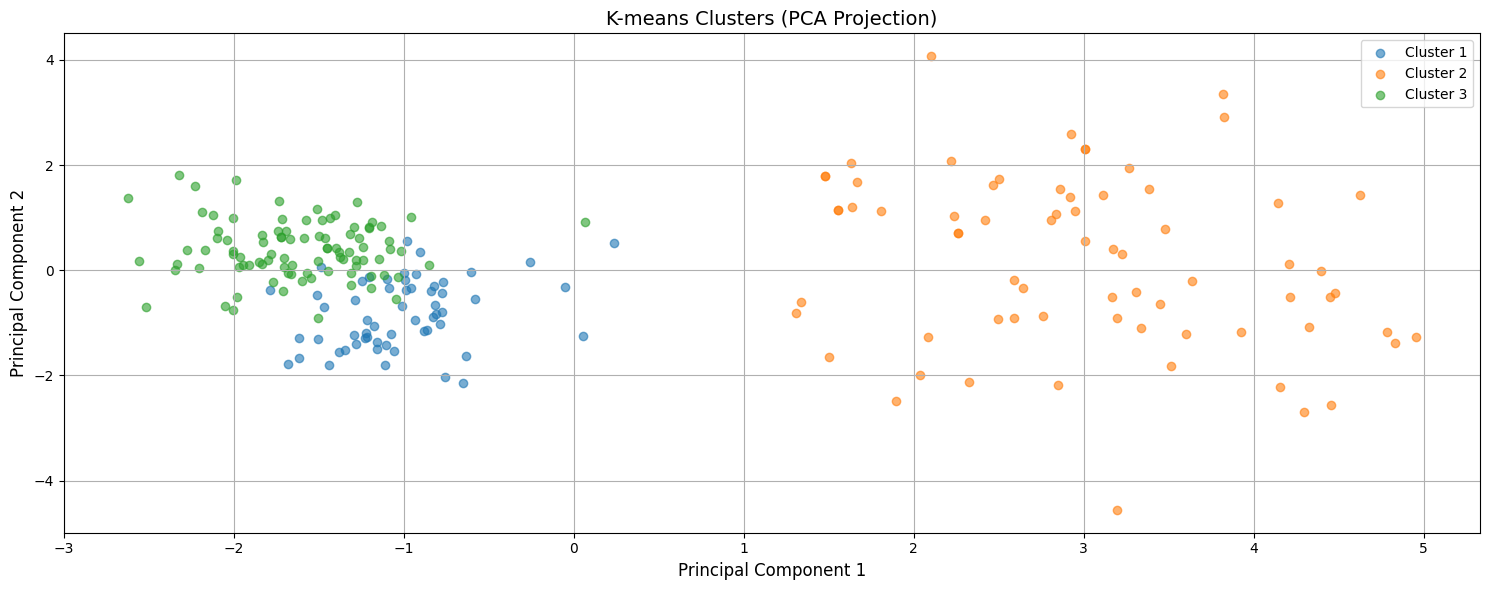

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_scaled)
df_gender['cluster'] = kmeans.labels_
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(15, 6))
for cluster in range(3):
    plt.scatter(X_pca[df_gender['cluster'] == cluster, 0], X_pca[df_gender['cluster'] == cluster, 1],
                label=f'Cluster {cluster + 1}', alpha=0.6)
plt.title('K-means Clusters (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

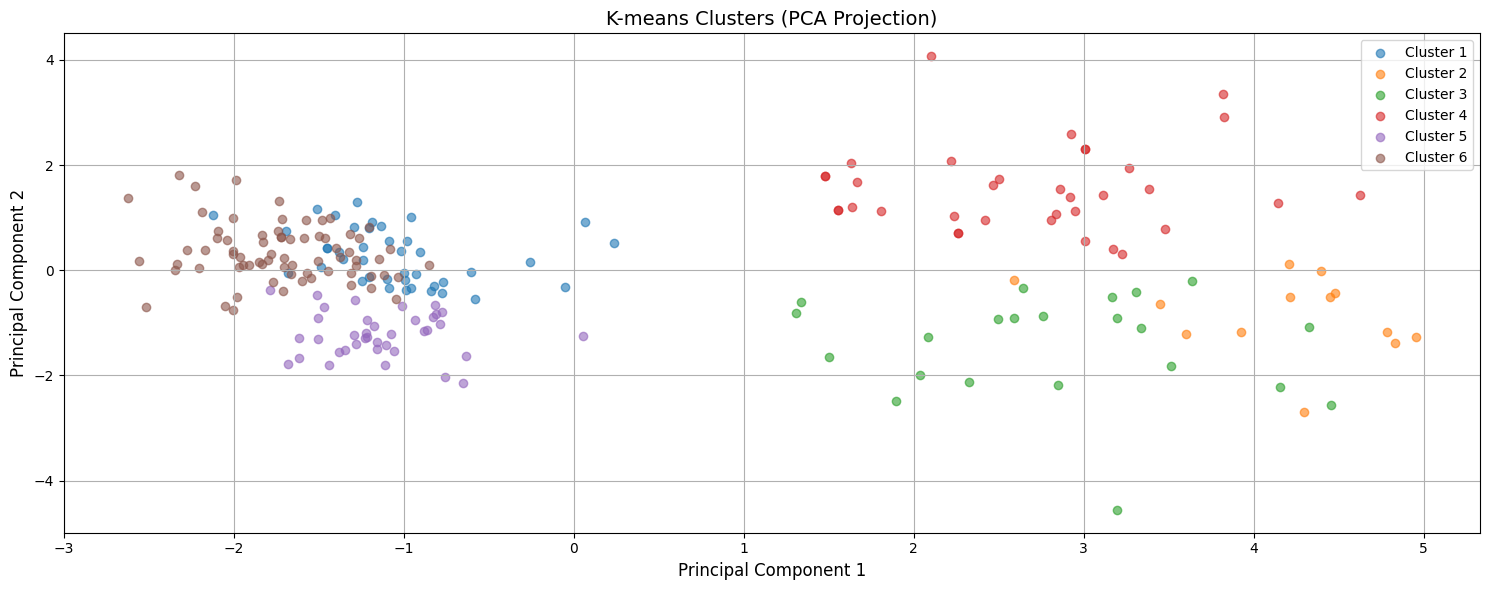

In [ ]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_scaled)
df_gender['cluster'] = kmeans.labels_
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(15, 6))
for cluster in range(6):
    plt.scatter(X_pca[df_gender['cluster'] == cluster, 0], X_pca[df_gender['cluster'] == cluster, 1],
                label=f'Cluster {cluster + 1}', alpha=0.6)
plt.title('K-means Clusters (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Guassian mixture Gender

In [ ]:

X = df_gender.drop(columns=['Gender'])
y = df_gender['Gender']
scaler = StandardScaler()
X = scaler.fit_transform(X)

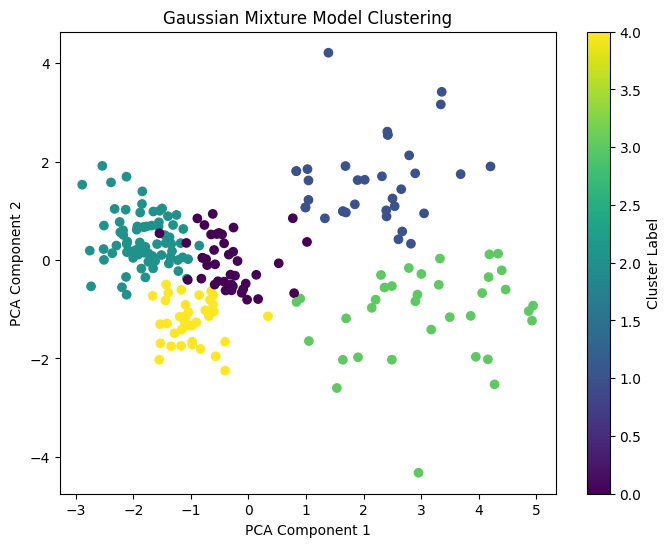

Cluster Centers (means of the Gaussians):
[[ 0.01421153 -0.51273832 -0.30442624 -0.54179202  0.5969575   0.58765576
  -0.11596516  0.         -1.6355177 ]
 [ 0.51649945  1.12013187  1.76018852  1.51366986  0.13887949  0.7200453
   0.34282638  0.         -0.02669243]
 [-0.87633887 -0.77470767 -0.48067191 -0.62331056 -0.19456953  0.35097503
  -0.87568963  0.          1.04585776]
 [ 1.39446078  1.677755    0.58991393  1.1476615  -0.9126426  -1.22481446
   1.32254476  0.         -0.76215541]
 [-0.1149969  -0.55591625 -0.92536139 -0.68565169  0.43724888 -0.83413599
   0.25042722  0.          0.50958267]]


In [ ]:
gmm = GaussianMixture(n_components=5)
gmm.fit(X)

labels = gmm.predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()
print("Cluster Centers (means of the Gaussians):")
print(gmm.means_)

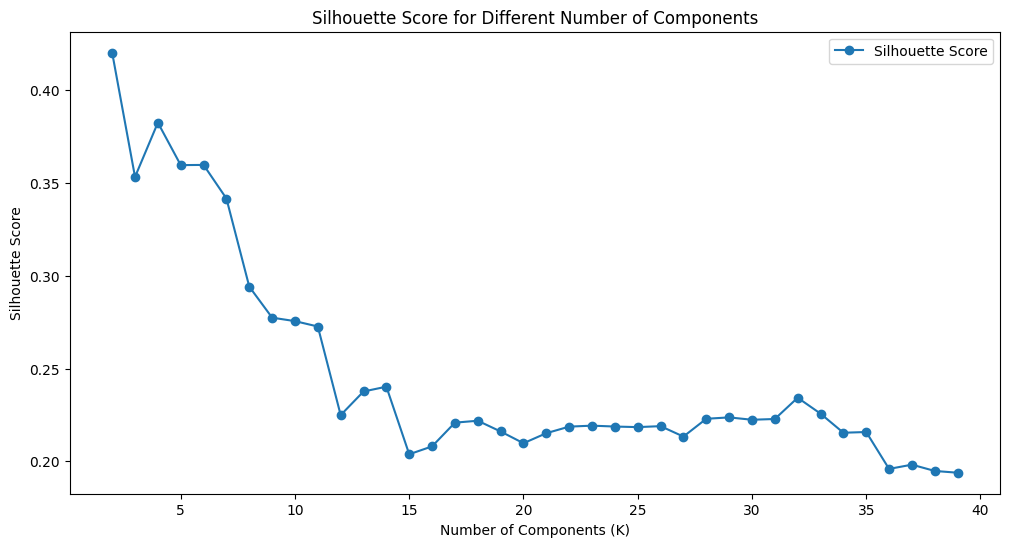

Best number of components (based on Silhouette Score): 2


In [ ]:
X_scaled = X
k_values = range(1,40)
silhouette_scores = []
for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    if k > 1:
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan)
k_values = k_values[1:]
silhouette_scores = [score for score in silhouette_scores if not np.isnan(score)]
plt.figure(figsize=(12, 6))
plt.plot(k_values, silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Score for Different Number of Components')
plt.xlabel('Number of Components (K)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()
best_k_silhouette = k_values[np.argmax(silhouette_scores)]
print(f"Best number of components (based on Silhouette Score): {best_k_silhouette}")

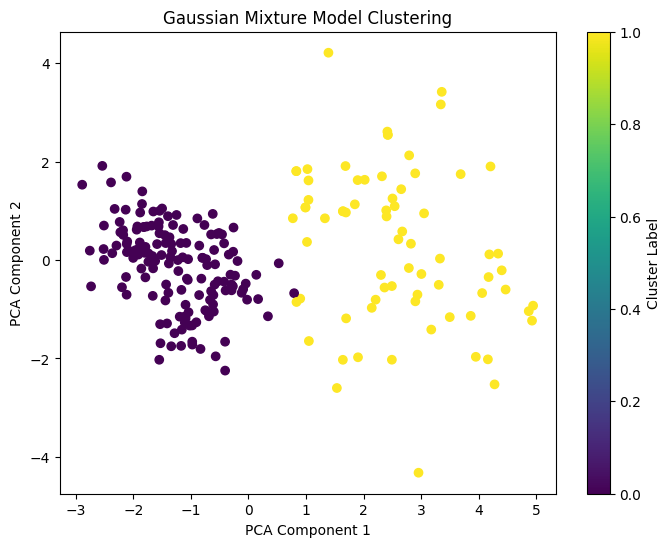

Cluster Centers (means of the Gaussians):
[[-0.44855133 -0.66626354 -0.55526693 -0.62696596  0.18377516  0.10444947
  -0.39448868  0.          0.20725308]
 [ 0.92825206  1.37879539  1.14909407  1.29747123 -0.38031247 -0.21615237
   0.81637242  0.         -0.42889874]]


In [ ]:
gmm = GaussianMixture(n_components=best_k_silhouette)
gmm.fit(X)
labels = gmm.predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()
print("Cluster Centers (means of the Gaussians):")
print(gmm.means_)

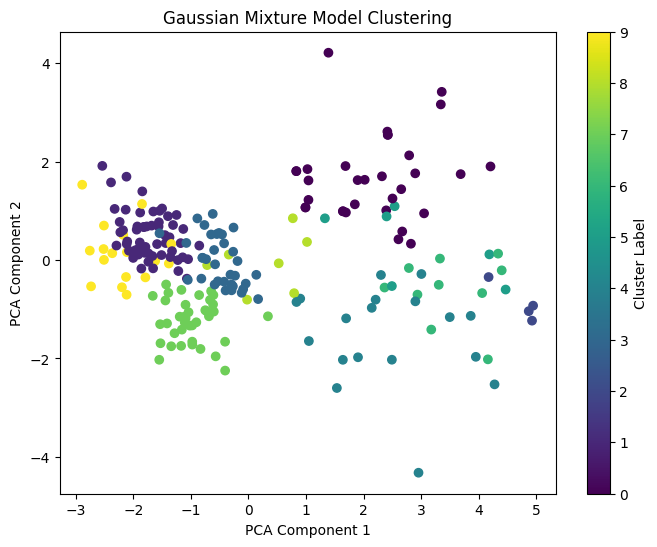

Cluster Centers (means of the Gaussians):
[[ 0.44842441  1.1373222   1.82279583  1.59879972  0.08094815  0.65007795
   0.21627728  0.         -0.02669243]
 [-0.72074169 -0.72540349 -0.43062523 -0.61411431 -0.07138046  0.51052926
  -0.80335027  0.          1.04585776]
 [ 2.83474604  2.06557152  0.86998185  0.88310318 -2.18992279  0.42913089
   3.20797311  0.         -1.09924261]
 [-0.03866921 -0.59579832 -0.33424794 -0.57973195  0.63435405  0.55878427
  -0.22194369  0.         -1.6355177 ]
 [ 0.94834195  1.60751774  0.13096193  0.83684916 -0.44149593 -1.67987009
   1.070695    0.         -0.65238124]
 [ 1.6063226   1.22873903  1.17211754  0.85304807  0.81967039  0.82183988
   2.17935038  0.         -0.56296756]
 [ 1.44878599  1.69618516  1.10559382  1.82728153 -1.7885895  -1.48789678
   0.61857937  0.         -0.7238008 ]
 [-0.1149969  -0.55591625 -0.92536139 -0.68565169  0.43724888 -0.83413599
   0.25042722  0.          0.50958267]
 [ 0.27119972 -0.10908587 -0.15949966 -0.35741271  0.4

In [ ]:
gmm = GaussianMixture(n_components=10)
gmm.fit(X)
labels = gmm.predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()
print("Cluster Centers (means of the Gaussians):")
print(gmm.means_)

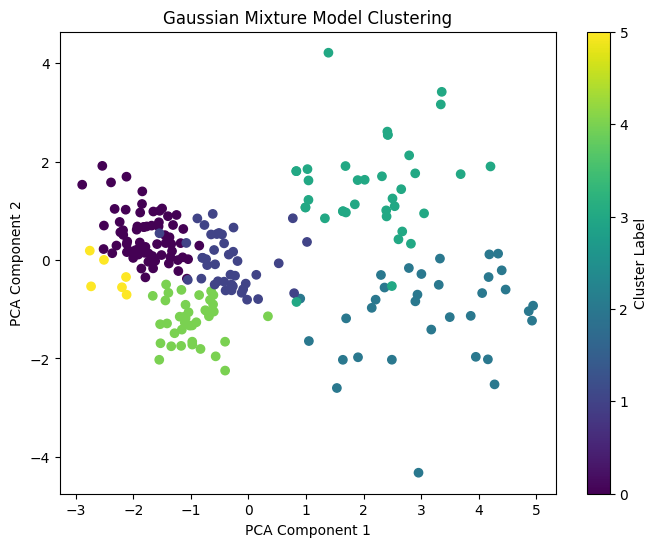

Cluster Centers (means of the Gaussians):
[[-0.81541853 -0.75575212 -0.44170385 -0.61711222 -0.19072732  0.44528805
  -0.85130222  0.          1.04585776]
 [ 0.01421153 -0.51273832 -0.30442624 -0.54179202  0.5969575   0.58765576
  -0.11596516  0.         -1.6355177 ]
 [ 1.42478849  1.73069723  0.60984877  1.19656419 -0.99904444 -1.27793945
   1.32937516  0.         -0.75800649]
 [ 0.53702888  1.10314052  1.67900488  1.45023511  0.15894361  0.66203488
   0.38982032  0.         -0.07024138]
 [-0.1149969  -0.55591625 -0.92536139 -0.68565169  0.43724888 -0.83413599
   0.25042722  0.          0.50958267]
 [-1.5464585  -0.98321744 -0.90931789 -0.69149186 -0.23683359 -0.68646181
  -1.14394939  0.          1.04585776]]


In [ ]:
gmm = GaussianMixture(n_components=6)
gmm.fit(X)
labels = gmm.predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()
print("Cluster Centers (means of the Gaussians):")
print(gmm.means_)